In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timezone, timedelta
from io import StringIO
import geohash2
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math
# Gloabl seaborn Theme
sns.set_theme(style="whitegrid", palette="pastel")

# Extraction - PM25 Raw

In [2]:
# Time Period to Calculate NowCast AQI
#
# AQICN: https://aqicn.org/faq/2015-03-15/air-quality-nowcast-a-beginners-guide/
# AirNow: http://airnow.gov/
# NowCast: https://en.wikipedia.org/wiki/NowCast_(air_quality_index)
#
#
parameters = catalog.load('parameters')
# Current DateTime
nowcast_datetime = parameters['nowcast_datetime']
nowcast_timestamp = int(datetime.fromisoformat(nowcast_datetime).timestamp() * 1000)
# Start DateTime
start_datetime = (datetime.fromisoformat(nowcast_datetime) - timedelta(hours=24)).isoformat()
start_timestamp = int(datetime.fromisoformat(start_datetime).timestamp() * 1000)

print(
    'nowcast_datetime:', nowcast_datetime,
    'timestamp:', nowcast_timestamp,
    ':: start_datetime:', start_datetime,
    'timestamp:', start_timestamp
)

2022-09-09 15:54:42,818 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...
nowcast_datetime: 2022-09-06T13:35:00 timestamp: 1662489300000 :: start_datetime: 2022-09-05T13:35:00 timestamp: 1662402900000


In [3]:
# Request to InfluxDB API REST
def request_to_influxdb(sql_query):
    endpoint = "http://influxdb.canair.io:8086/query"
    database = "canairio"
    parameters = {
        'db': database,
        'q': sql_query,
        'epoch': 'ms'
    }
    # To get response as CSV text
    headers = {'Accept': 'application/csv'}
    # GET Request
    return requests.get(endpoint, params=parameters, headers=headers)

In [4]:
# Get SQL Query Tangaras
def get_sql_query_tangaras(start_datetime, end_datetime):
    sql_query = ""
    # Period DateTime
    period_time = f"time >= {start_datetime}ms AND time <= {end_datetime}ms"
    # SQL
    sql_query = "SELECT DISTINCT(geo) AS \"geohash\" "\
                "FROM \"fixed_stations_01\" WHERE "\
                    "(\"geo3\" = 'd29') AND "\
                    f"{period_time} "\
                "GROUP BY \"name\";"
    return sql_query

In [5]:
# SQL Query Tangaras
sql_query = get_sql_query_tangaras(start_timestamp, nowcast_timestamp)
print(sql_query)

SELECT DISTINCT(geo) AS "geohash" FROM "fixed_stations_01" WHERE ("geo3" = 'd29') AND time >= 1662402900000ms AND time <= 1662489300000ms GROUP BY "name";


In [6]:
# Get Data Frame Tangaras
def get_df_tangaras(start_datetime, end_datetime):
    # SQL Query Tangaras
    sql_query = get_sql_query_tangaras(start_datetime, end_datetime)
    # InfluxDB API REST Request
    influxdb_api_request = request_to_influxdb(sql_query)
    #print(influxdb_api_request)
    df_tangaras = pd.read_csv(StringIO(influxdb_api_request.text), sep=",")
    
    # Remove/Add Columns
    df_tangaras = df_tangaras[['tags', 'geohash']]
    df_tangaras['MAC'] = df_tangaras['tags'].apply(lambda x: x.split('=')[1])
    df_tangaras['GEOLOCATION'] = df_tangaras['geohash'].apply(lambda x: " ".join(str(value) for value in list(geohash2.decode_exactly(x)[0:2])))
    df_tangaras['LATITUDE'] = df_tangaras['GEOLOCATION'].apply(lambda x: x.split(' ')[0])
    df_tangaras['LONGITUDE'] = df_tangaras['GEOLOCATION'].apply(lambda x: x.split(' ')[1])
    df_tangaras['tags'] = df_tangaras['tags'].apply(lambda x: f"TANGARA_{x[-4:]}")
    df_tangaras.rename(columns={'tags': 'ID', 'geohash': 'GEOHASH'}, inplace=True)
    # Date time when query is executed
    tz = timezone(timedelta(hours=-5))
    df_tangaras['DATETIME'] = datetime.now(tz=tz)

    return df_tangaras

In [7]:
# Data Frame Tangaras
tangaras = get_df_tangaras(start_timestamp, nowcast_timestamp)
tangaras.head()

,ID,GEOHASH,MAC,GEOLOCATION,LATITUDE,LONGITUDE,DATETIME
0,TANGARA_2BBA,d29e6b4,D29ESP32DE02BBA,3.3844757080078125 -76.51634216308594,3.3844757080078125,-76.51634216308594,2022-09-09 15:54:44.377625-05:00
1,TANGARA_14D6,d29dfx4,D29ESP32DED14D6,3.3350372314453125 -76.52732849121094,3.3350372314453125,-76.52732849121094,2022-09-09 15:54:44.377625-05:00
2,TANGARA_1CE2,d29e4cv,D29ESP32DED1CE2,3.3501434326171875 -76.51222229003906,3.3501434326171875,-76.51222229003906,2022-09-09 15:54:44.377625-05:00
3,TANGARA_1FCA,d29e48s,D29ESP32DED1FCA,3.3432769775390625 -76.52458190917969,3.3432769775390625,-76.52458190917969,2022-09-09 15:54:44.377625-05:00
4,TANGARA_2492,d29e64g,D29ESP32DED2492,3.3995819091796875 -76.54792785644531,3.3995819091796875,-76.54792785644531,2022-09-09 15:54:44.377625-05:00


In [8]:
# Save tangaras into Catalog
catalog.save('tangaras', tangaras)

2022-09-09 15:54:44,527 - kedro.io.data_catalog - INFO - Saving data to `tangaras` (CSVDataSet)...


In [9]:
# Get SQL Query Data Sensors
def get_sql_query_sensors(tangaras, start_datetime, end_datetime):
    sql_query = ""
    # Period DateTime
    period_time = f"time >= {start_datetime}ms AND time <= {end_datetime}ms"
    # SQL
    for mac in tangaras['MAC'].to_list():
        sql_query += "SELECT \"name\", last(\"pm25\") "\
                    "FROM \"fixed_stations_01\" WHERE "\
                    f"(\"name\" = '{mac}') AND "\
                    f"{period_time} " \
                    "GROUP BY time(30s) fill(none); "
    return sql_query[:-2]

In [10]:
# SQL Query Data Sensors
sql_query = get_sql_query_sensors(tangaras, start_timestamp, nowcast_timestamp)
#print(sql_query)

In [11]:
# Get Data Frame Sensors
def get_df_sensors(tangaras, start_datetime, end_datetime):
    # Data Frame Sensors
    df_sensors = []
    # SQL Query Data Sensors
    sql_query = get_sql_query_sensors(tangaras, start_datetime, end_datetime)
    # InfluxDB API REST Request
    influxdb_api_request = request_to_influxdb(sql_query)
    #print(influxdb_api_request)
    df_influxdb_api_sensors = pd.read_csv(StringIO(influxdb_api_request.text), sep=",")

    # Remove/Add Columns
    df_influxdb_api_sensors = df_influxdb_api_sensors[['time', 'name.1', 'last']]
    df_influxdb_api_sensors.rename(columns={'time': 'DATETIME', 'name.1': 'MAC', 'last': 'PM25'}, inplace=True)

    # Truncate Response
    for index, row in tangaras.iterrows():
        df_sensor = df_influxdb_api_sensors.loc[df_influxdb_api_sensors['MAC'] == row['MAC']].reset_index(drop=True)[['DATETIME', 'PM25']] # Warning
        if not df_sensor.empty:
            df_sensor.rename(columns={'PM25': row['ID']}, inplace=True)
            df_sensor.set_index('DATETIME', inplace=True)
            df_sensors.append(df_sensor)
    
    df_sensors = df_sensors[0].join(df_sensors[1:]).reset_index()

    tz = timezone(timedelta(hours=-5))
    df_sensors['DATETIME'] = df_sensors['DATETIME'].apply(lambda x: datetime.fromtimestamp(int(x) / 1000, tz=tz).isoformat())

    df_sensors[df_sensors.columns.to_list()[1:]] = df_sensors[df_sensors.columns.to_list()[1:]].astype('Int64')
    
    return df_sensors

In [12]:
# Data Frame Sensors
pm25_raw = get_df_sensors(tangaras, start_timestamp, nowcast_timestamp)
pm25_raw.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05T13:35:00-05:00,21,20,24,26,25,26,16,7,21,34,26,25,25
1,2022-09-05T13:35:30-05:00,20,20,23,25,24,25,15,7,19,42,26,25,26
2,2022-09-05T13:36:00-05:00,20,20,24,166,23,26,16,8,18,39,27,25,24
3,2022-09-05T13:36:30-05:00,21,20,24,64,25,24,16,8,19,36,29,25,24
4,2022-09-05T13:37:00-05:00,22,22,24,49,26,26,14,7,19,39,29,26,23


In [13]:
# Check Data Types
pm25_raw.dtypes

DATETIME        object
TANGARA_2BBA     Int64
TANGARA_14D6     Int64
TANGARA_1CE2     Int64
TANGARA_1FCA     Int64
TANGARA_2492     Int64
TANGARA_2FF6     Int64
TANGARA_48C6     Int64
TANGARA_4D7A     Int64
TANGARA_532E     Int64
TANGARA_EA06     Int64
TANGARA_F1AE     Int64
TANGARA_FAC6     Int64
TANGARA_06BE     Int64
dtype: object

In [14]:
# Save pm25_raw into Catalog
catalog.save('pm25_raw', pm25_raw)

2022-09-09 15:54:49,361 - kedro.io.data_catalog - INFO - Saving data to `pm25_raw` (CSVDataSet)...


---

# Extraction - PM25 Clean, without outliers

In [15]:
# Kedro Catalog
pm25_raw = catalog.load('pm25_raw')

2022-09-09 15:54:49,509 - kedro.io.data_catalog - INFO - Loading data from `pm25_raw` (CSVDataSet)...


In [16]:
# Data Frame Sensors
pm25_raw.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05T13:35:00-05:00,21,20.0,24.0,26.0,25.0,26.0,16.0,7.0,21.0,34.0,26.0,25.0,25.0
1,2022-09-05T13:35:30-05:00,20,20.0,23.0,25.0,24.0,25.0,15.0,7.0,19.0,42.0,26.0,25.0,26.0
2,2022-09-05T13:36:00-05:00,20,20.0,24.0,166.0,23.0,26.0,16.0,8.0,18.0,39.0,27.0,25.0,24.0
3,2022-09-05T13:36:30-05:00,21,20.0,24.0,64.0,25.0,24.0,16.0,8.0,19.0,36.0,29.0,25.0,24.0
4,2022-09-05T13:37:00-05:00,22,22.0,24.0,49.0,26.0,26.0,14.0,7.0,19.0,39.0,29.0,26.0,23.0


## Descriptive Statistics

In [17]:
# Describe Data
pm25_raw.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2838.000000,2747.000000,2796.000000,842.000000,2779.000000,2801.000000,2807.000000,2763.000000,2692.000000,2755.000000,2770.000000,2739.000000,2793.000000
mean,21.417195,24.116491,25.281474,38.681710,27.880533,26.601928,16.470609,5.638075,16.235884,32.560436,28.472924,21.766338,25.704261
std,5.746803,5.982577,6.981280,59.070996,11.151621,5.989012,6.511554,2.852142,8.509186,20.869400,12.251082,15.567362,5.954451
min,10.000000,12.000000,12.000000,23.000000,13.000000,14.000000,0.000000,2.000000,3.000000,9.000000,11.000000,9.000000,15.000000
25%,17.000000,20.000000,21.000000,27.000000,23.000000,22.000000,11.000000,3.000000,8.000000,15.000000,17.000000,11.000000,21.000000
50%,21.000000,23.000000,25.000000,29.000000,26.000000,26.000000,17.000000,5.000000,15.000000,29.000000,29.000000,20.000000,25.000000
75%,25.000000,28.000000,30.000000,31.000000,31.000000,30.000000,21.000000,8.000000,24.000000,48.000000,39.000000,31.000000,30.000000
max,44.000000,72.000000,56.000000,1110.000000,182.000000,42.000000,60.000000,12.000000,86.000000,583.000000,170.000000,449.000000,51.000000


In [18]:
# Plot Histograms
def histplots(data_sensors):
    # Canvas
    fig, axes = plt.subplots(4, 4, figsize=(22, 16), constrained_layout=True)
    fig.suptitle('Histograms - Data Sensors', fontsize=20)
    # Plot
    size = len(data_sensors.describe().columns)
    k = 1
    for i in range(0, 4):
        for j in range(0, 4):
            if k <= size:
                sns.histplot(ax=axes[i, j], data=data_sensors[data_sensors.columns[k]])
            k += 1

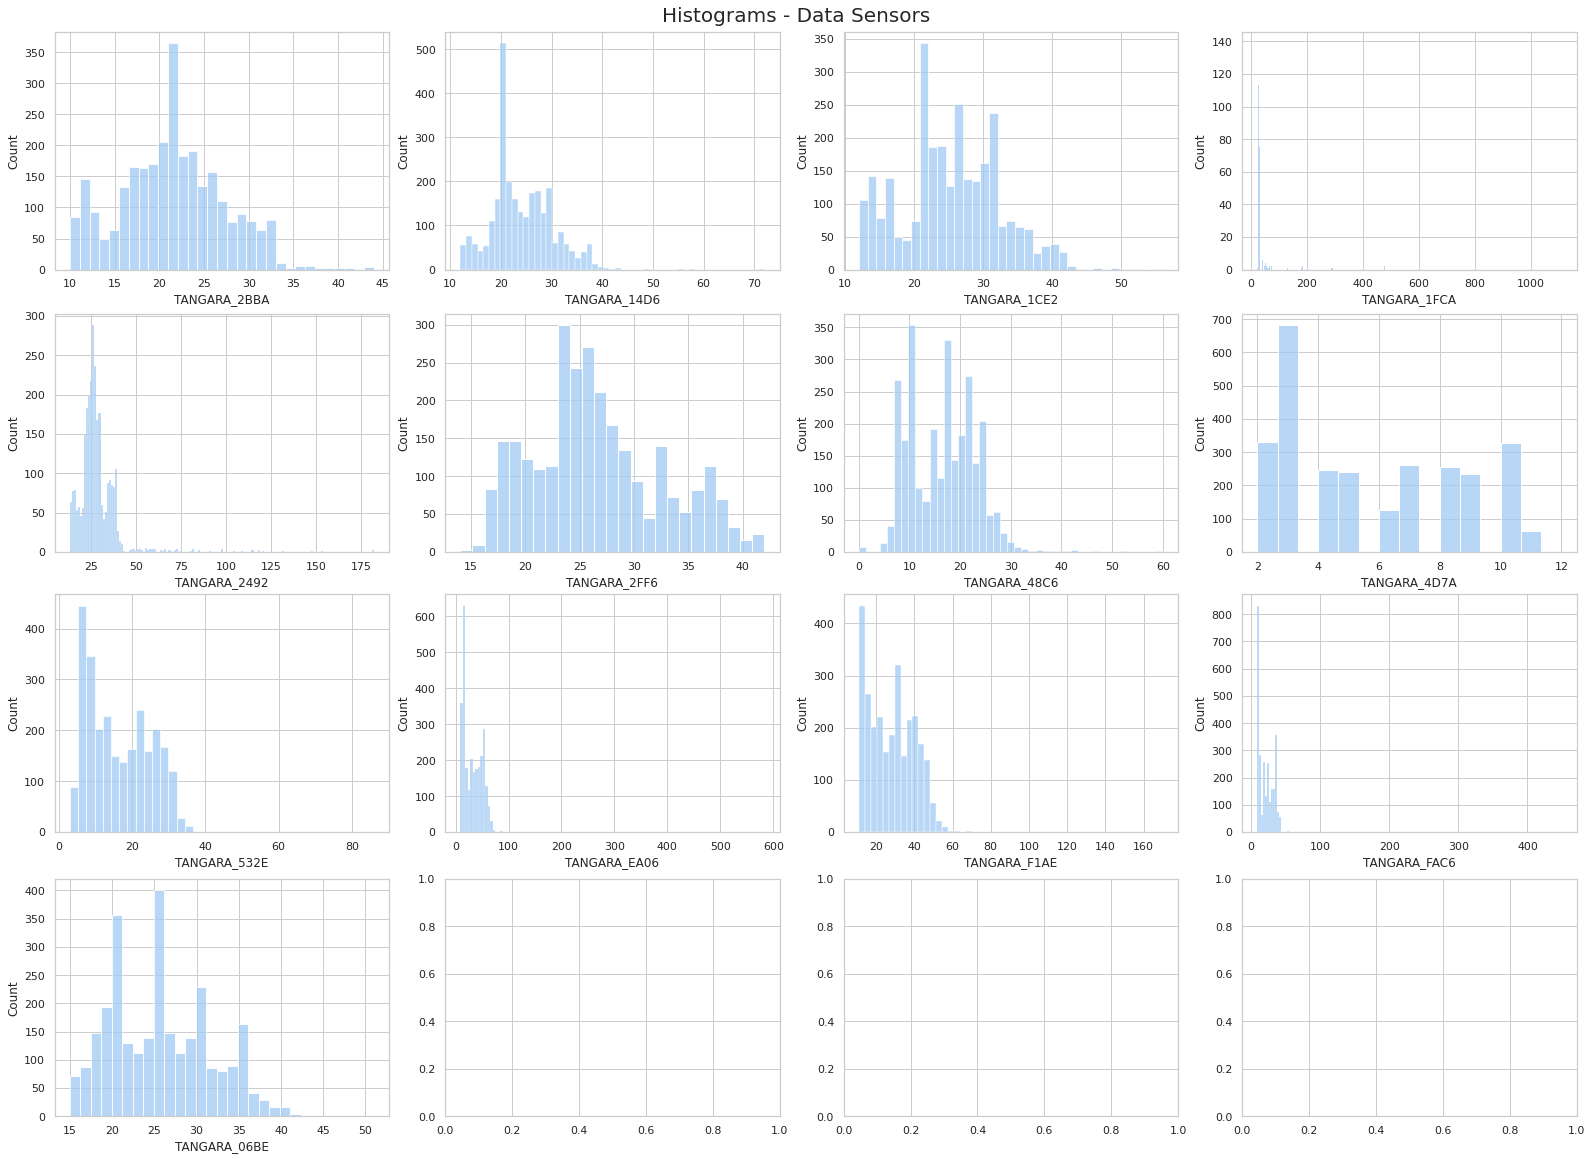

In [19]:
# Plot Histograms
histplots(pm25_raw)

In [20]:
# Plot Boxplots
def boxplots(data_sensors):
    # Canvas
    fig, axes = plt.subplots(4, 4, figsize=(22, 16), constrained_layout=True)
    fig.suptitle('Boxplots - Data Sensors', fontsize=20)
    # Plot
    size = len(data_sensors.describe().columns)
    k = 1
    for i in range(0, 4):
        for j in range(0, 4):
            if k <= size:
                sns.boxplot(ax=axes[i, j], data=data_sensors[data_sensors.columns[k]], orient="h", x=data_sensors[data_sensors.columns[k]])
            k += 1

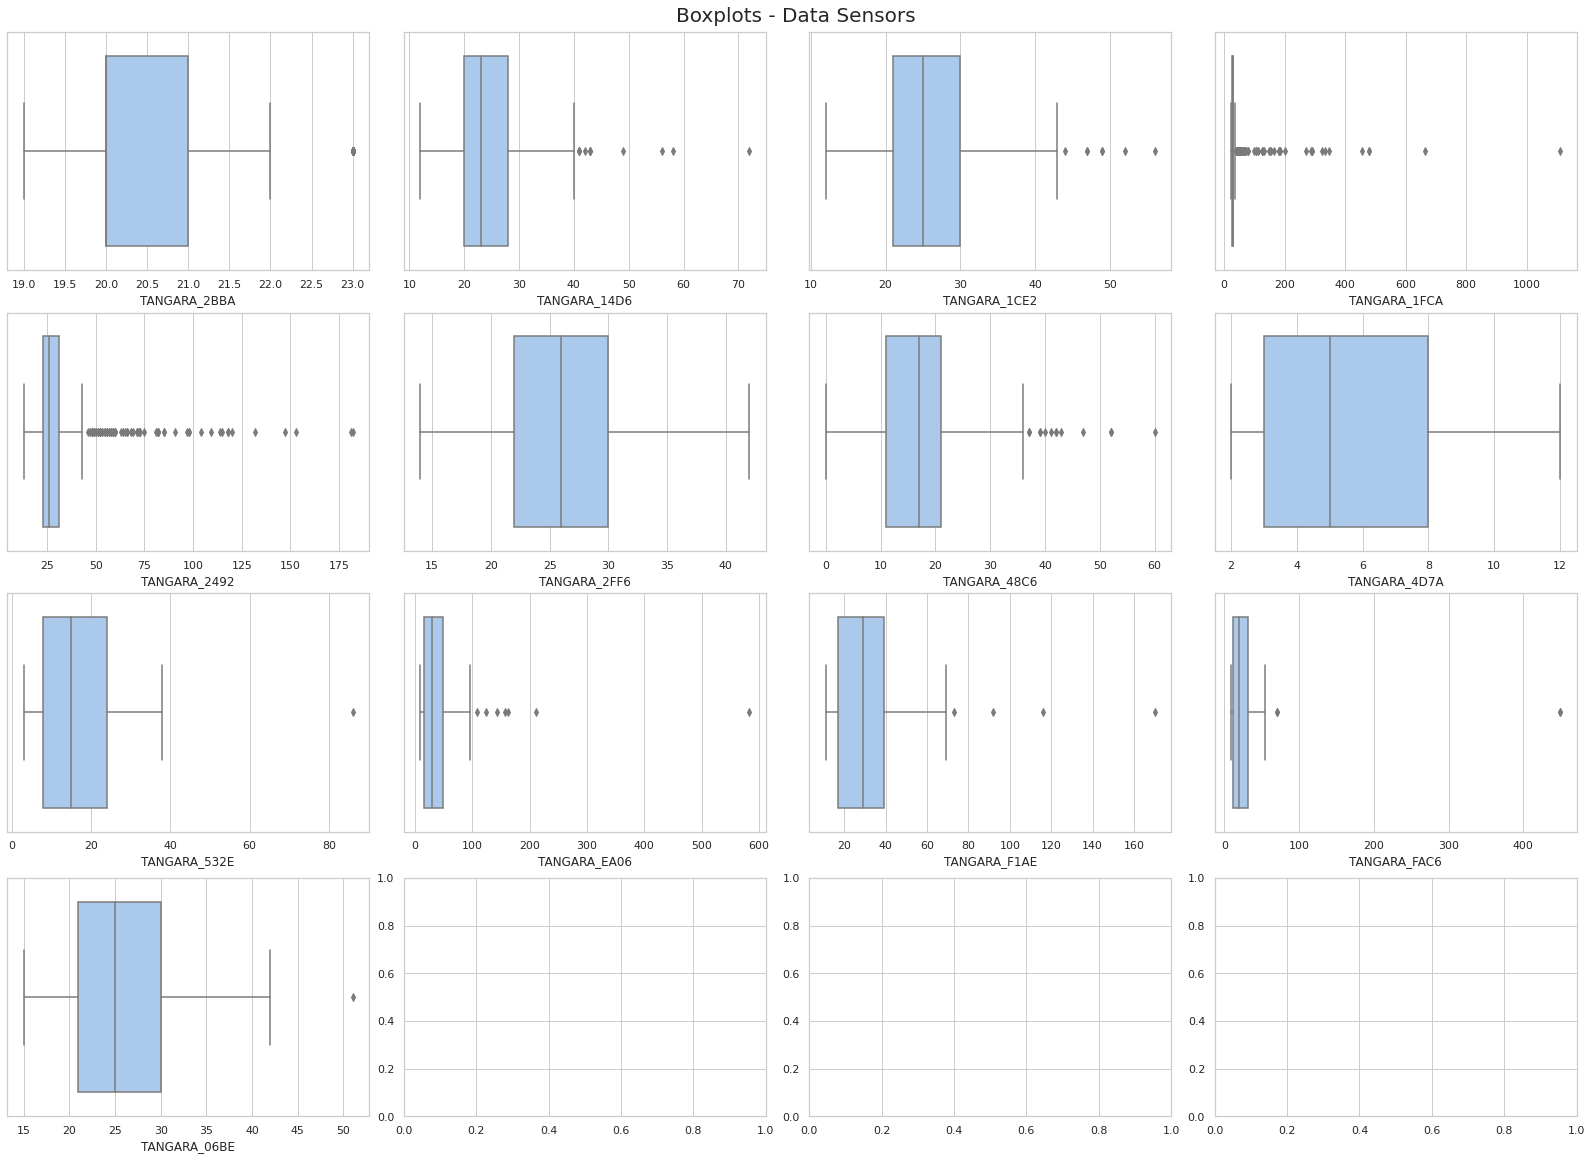

In [21]:
# Plot Boxplots
boxplots(pm25_raw)

---

## Air Quality Index - AQI - Basics

### What is the U.S. Air Quality Index - AQI?

The U.S. AQI is EPA’s index for reporting air quality.

[AQI - Basics](https://www.airnow.gov/aqi/aqi-basics/)

[Technical Assistance Document for the Reporting of Daily Air Quality – the Air Quality Index - AQI](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf)

| Using Table 5, find the two breakpoints that contain the concentration. | AQI for Ozone and Particle Pollution |
| --- | --- |
| <img src="breakpoints_aqi.png" alt="Breakpoints for the AQI" width="auto"/> | <img src="categories_aqi.png" alt="Categories for the AQI" width="auto"/> |


### Calculating the AQI

**How do I Calculate the AQI from pollutant concentration data?**

The AQI is the highest value calculated for each pollutan as follows:

    A. Identify the highest concentration among all of the monitors within each reporting area and truncate as follow:

<img src="pollutants.png" alt="Pollutants" width="auto"/>

    B. Using Table 5, find the two breakpoints tha contain the concentration.

    C. Using Equation 1, calculate the index

<img src="equation1.png" alt="Equation 1" width="auto"/>

    D. Round the index to the nearest integer


### Constants

In [22]:
# Levels of Concern
GOOD = 0
MODERATE = 1
UNHEALTHY_FOR_SENSITIVE_GROUPS = 2
UNHEALTHY = 3
VERY_UNHEALTHY = 4
HAZARDOUS = 5
# AQI Levels
AQI_LEVELS = (
    (GOOD, 'Good', [0, 50]), # 0 - 50
    (MODERATE, 'Moderate', [51, 100]), # 51 - 100
    (UNHEALTHY_FOR_SENSITIVE_GROUPS, 'Unhealthy for sensitive groups', [101, 150]), # 101 - 150
    (UNHEALTHY, 'Unhealthy', [151, 200]), # 151 - 200
    (VERY_UNHEALTHY, 'Very Unhealthy', [201, 300]), # 201 - 300
    (HAZARDOUS, 'Hazardous', [301, sys.maxsize]), # 301 - higher
)
# PM25 Breakpoints Values
PM25_BREAKPOINTS = (
    (GOOD, 'Good', [0.0, 12.0]), # 0.0 - 12.0, Good
    (MODERATE, 'Moderate', [12.1, 35.4]), # 12.1 - 35.4, Moderate
    (UNHEALTHY_FOR_SENSITIVE_GROUPS, 'Unhealthy for sensitive groups', [35.5, 55.4]), # 35.5 - 55.4, Unhealthy for sensitive groups
    (UNHEALTHY, 'Unhealthy', [55.5, 150.4]), # 55.5 - 150.4, Unhealthy
    (VERY_UNHEALTHY, 'Very Unhealthy', [150.5, 250.4]), # 150.5 - 250.4, Very Unhealthy
    (HAZARDOUS, 'Hazardous', [250.5, 350.4]), # 250.5 - 350.4, Hazardous
    (HAZARDOUS, 'Hazardous', [350.5, 500.4]), # 350.5 - 500.4, Hazardous
)
# Max PM25 Value
MAX_PM25_VALUE = 500.5

### Equation 1

In [23]:
# Define Equation 1 to Calculate AQI Value
#
# AQI = AQI for pollutant p
# Cp = The truncated concentrattion of pollutant p
# BP_hi = The concentration breakpoint that is greater than or equal to Cp
# BP_lo = The concentration breakpoint that is less than or equal to Cp
# AQI_hi = The AQI value corresponding to BP_hi
# AQI_lo = The AQI value corresponding to BP_lo
#
def equation1(Cp):
    # AQI Value to Concentration of Pollutant P
    AQI = None
    # Variables
    BP_hi = None
    BP_lo = None
    AQI_hi = None
    AQI_lo = None

    # Get BP_hi and BP_lo
    for bp in PM25_BREAKPOINTS:
        #print('bp:', bp)
        if (Cp >= bp[2][0]) and (Cp <= bp[2][-1]):
            BP_hi = bp[2][-1]
            BP_lo = bp[2][0]
            AQI_hi = AQI_LEVELS[bp[0]][2][-1]
            AQI_lo = AQI_LEVELS[bp[0]][2][0]
            break

    AQI = math.ceil((((AQI_hi - AQI_lo) / (BP_hi - BP_lo)) * (Cp - BP_lo)) + AQI_lo)
    #print('Cp:', Cp, 'BP_hi:', BP_hi, 'BP_lo:', BP_lo, 'AQI_hi:', AQI_hi, 'AQI_lo:', AQI_lo, 'AQI:', AQI)
    #print('Cp:', Cp, 'AQI:', AQI)

    return AQI

In [24]:
# Equation 1 to calculate the AQI value
equation1(35.9)

102

---

## Drop Outliers

In [25]:
# Drop Outliers
def drop_outliers(data_sensors):
    # Each Data Sensor
    for column in data_sensors.columns:
        if column != 'DATETIME':
            # Apply mask to max value allowed, Max AQI Scale Value
            data_sensors[column] = data_sensors[column].mask(data_sensors[column] > MAX_PM25_VALUE, MAX_PM25_VALUE)
            
            # Standard Deviation
            std = data_sensors[column].std()
            # Range = max value - min value
            rango = data_sensors[column].max() - data_sensors[column].min()
            # Quantiles
            media = data_sensors[column].median()
            Q1 = data_sensors[column].quantile(q=0.25)
            Q2 = data_sensors[column].quantile(q=0.50)
            Q3 = data_sensors[column].quantile(q=0.75)
            min_val = data_sensors[column].quantile(q=0)
            max_val = data_sensors[column].quantile(q=1.0)
            # Interquartil Range
            iqr = Q3 - Q1
            # Limites para deteccion de outliers (solo aplica para datos simetricamente distribuidos)**
            min_limit = Q1 - 1.5 * iqr
            max_limit = Q3 + 1.5 * iqr
            # Medidas de Tendencia Central**
            str_resume = f"{column}:\n"\
                        f"std: {std}\n"\
                        f"rango: {rango}\n"\
                        f"media: {media}\n"\
                        f"Q1: {Q1}\n"\
                        f"Q2: {Q2}\n"\
                        f"Q3: {Q3}\n"\
                        f"min_val: {min_val}\n"\
                        f"max_val: {max_val}\n"\
                        f"iqr: {iqr}\n"\
                        f"min_limit: {min_limit}\n"\
                        f"max_limit: {max_limit}\n\n"
            #print(str_resume)

            # Drop Outliers, using max_limit to apply mask and drop outliers
            data_sensors[column] = data_sensors[column].mask(data_sensors[column] > max_limit, None)
    
    return data_sensors

In [26]:
# Eliminar Outliers
pm25_clean = drop_outliers(pm25_raw.copy())
pm25_clean.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05T13:35:00-05:00,21.0,20.0,24.0,26.0,25.0,26.0,16.0,7.0,21.0,34.0,26.0,25.0,25.0
1,2022-09-05T13:35:30-05:00,20.0,20.0,23.0,25.0,24.0,25.0,15.0,7.0,19.0,42.0,26.0,25.0,26.0
2,2022-09-05T13:36:00-05:00,20.0,20.0,24.0,NaN,23.0,26.0,16.0,8.0,18.0,39.0,27.0,25.0,24.0
3,2022-09-05T13:36:30-05:00,21.0,20.0,24.0,NaN,25.0,24.0,16.0,8.0,19.0,36.0,29.0,25.0,24.0
4,2022-09-05T13:37:00-05:00,22.0,22.0,24.0,NaN,26.0,26.0,14.0,7.0,19.0,39.0,29.0,26.0,23.0


In [27]:
# Describe Data
pm25_raw.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2838.000000,2747.000000,2796.000000,842.000000,2779.000000,2801.000000,2807.000000,2763.000000,2692.000000,2755.000000,2770.000000,2739.000000,2793.000000
mean,21.417195,24.116491,25.281474,38.681710,27.880533,26.601928,16.470609,5.638075,16.235884,32.560436,28.472924,21.766338,25.704261
std,5.746803,5.982577,6.981280,59.070996,11.151621,5.989012,6.511554,2.852142,8.509186,20.869400,12.251082,15.567362,5.954451
min,10.000000,12.000000,12.000000,23.000000,13.000000,14.000000,0.000000,2.000000,3.000000,9.000000,11.000000,9.000000,15.000000
25%,17.000000,20.000000,21.000000,27.000000,23.000000,22.000000,11.000000,3.000000,8.000000,15.000000,17.000000,11.000000,21.000000
50%,21.000000,23.000000,25.000000,29.000000,26.000000,26.000000,17.000000,5.000000,15.000000,29.000000,29.000000,20.000000,25.000000
75%,25.000000,28.000000,30.000000,31.000000,31.000000,30.000000,21.000000,8.000000,24.000000,48.000000,39.000000,31.000000,30.000000
max,44.000000,72.000000,56.000000,1110.000000,182.000000,42.000000,60.000000,12.000000,86.000000,583.000000,170.000000,449.000000,51.000000


In [28]:
# Describe Data
pm25_clean.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2825.000000,2736.000000,2789.000000,742.000000,2705.000000,2801.000000,2794.000000,2763.000000,2691.000000,2748.000000,2766.000000,2735.000000,2792.000000
mean,21.327788,24.020102,25.221585,28.367925,26.601109,26.601928,16.342878,5.638075,16.209959,32.102620,28.351048,21.418647,25.695201
std,5.604861,5.766191,6.884397,2.175981,6.408280,5.989012,6.234398,2.852142,8.403760,17.128851,11.751590,10.360962,5.936232
min,10.000000,12.000000,12.000000,23.000000,13.000000,14.000000,0.000000,2.000000,3.000000,9.000000,11.000000,9.000000,15.000000
25%,17.000000,20.000000,21.000000,27.000000,23.000000,22.000000,11.000000,3.000000,8.000000,15.000000,17.000000,11.000000,21.000000
50%,21.000000,23.000000,25.000000,28.000000,26.000000,26.000000,17.000000,5.000000,15.000000,29.000000,29.000000,20.000000,25.000000
75%,25.000000,28.000000,30.000000,30.000000,30.000000,30.000000,21.000000,8.000000,24.000000,48.000000,39.000000,31.000000,30.000000
max,37.000000,40.000000,43.000000,37.000000,43.000000,42.000000,36.000000,12.000000,38.000000,96.000000,69.000000,54.000000,42.000000


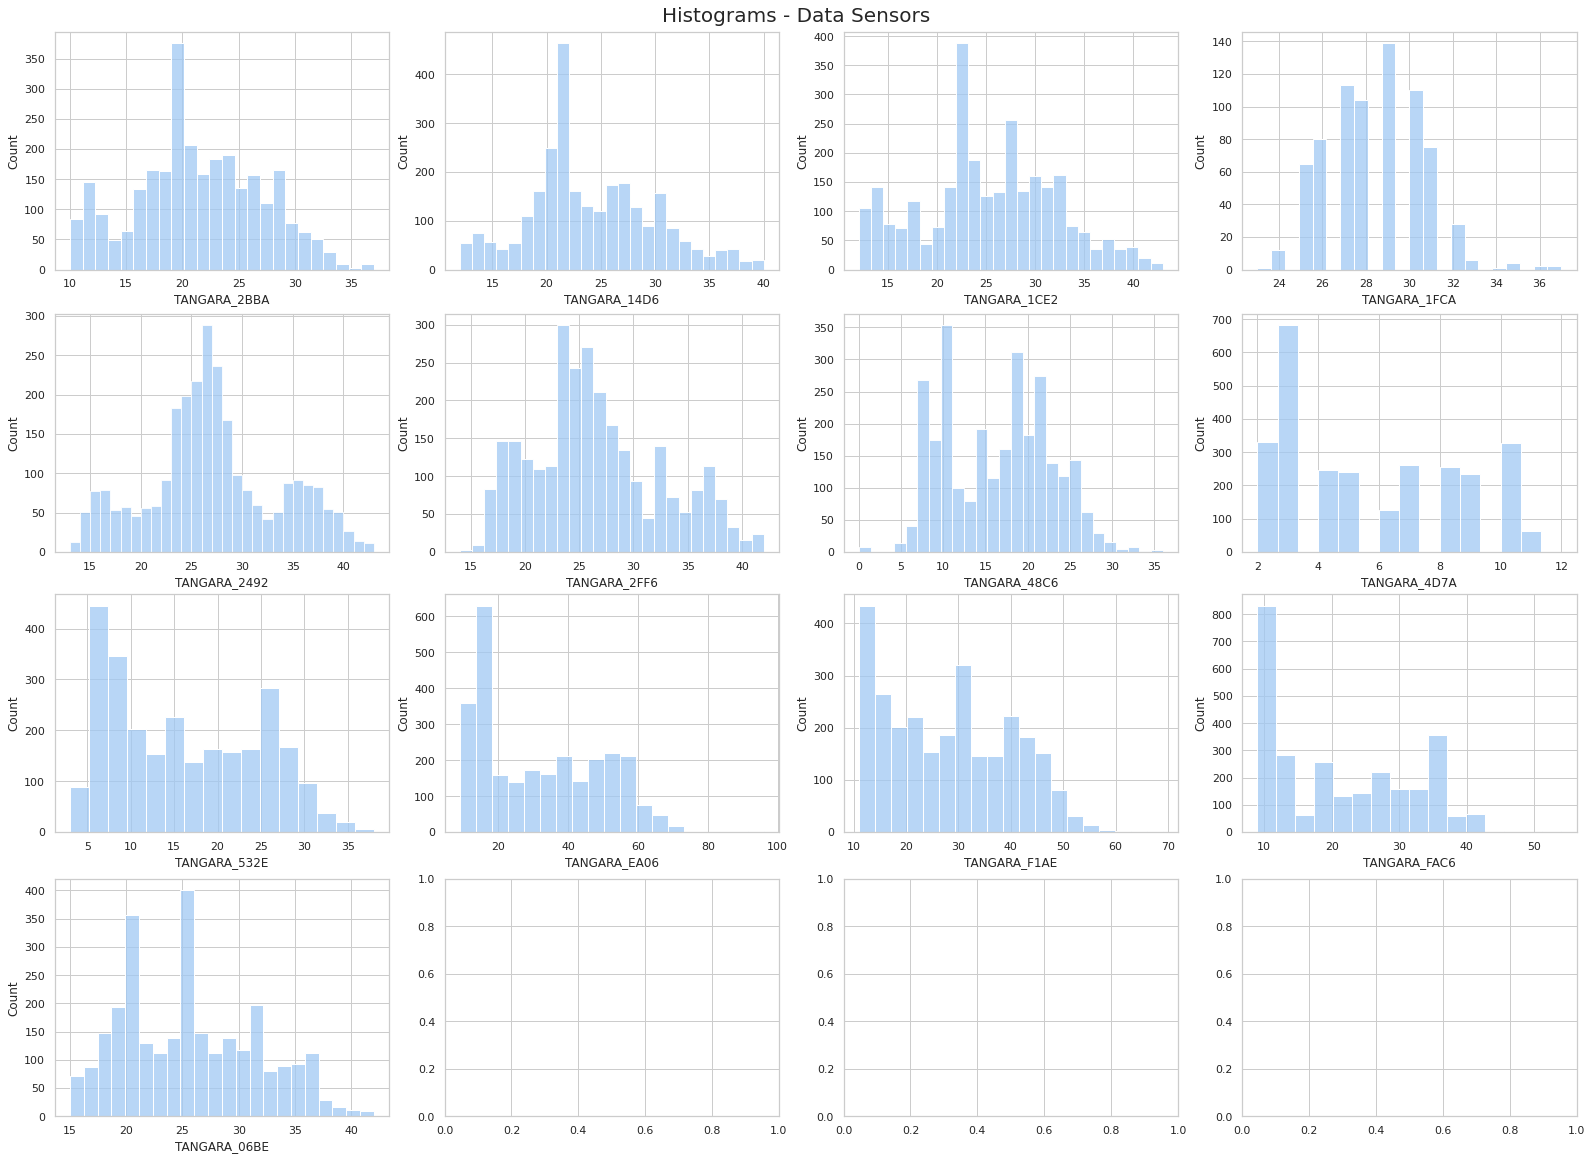

In [29]:
# Plot Histograms
histplots(pm25_clean)

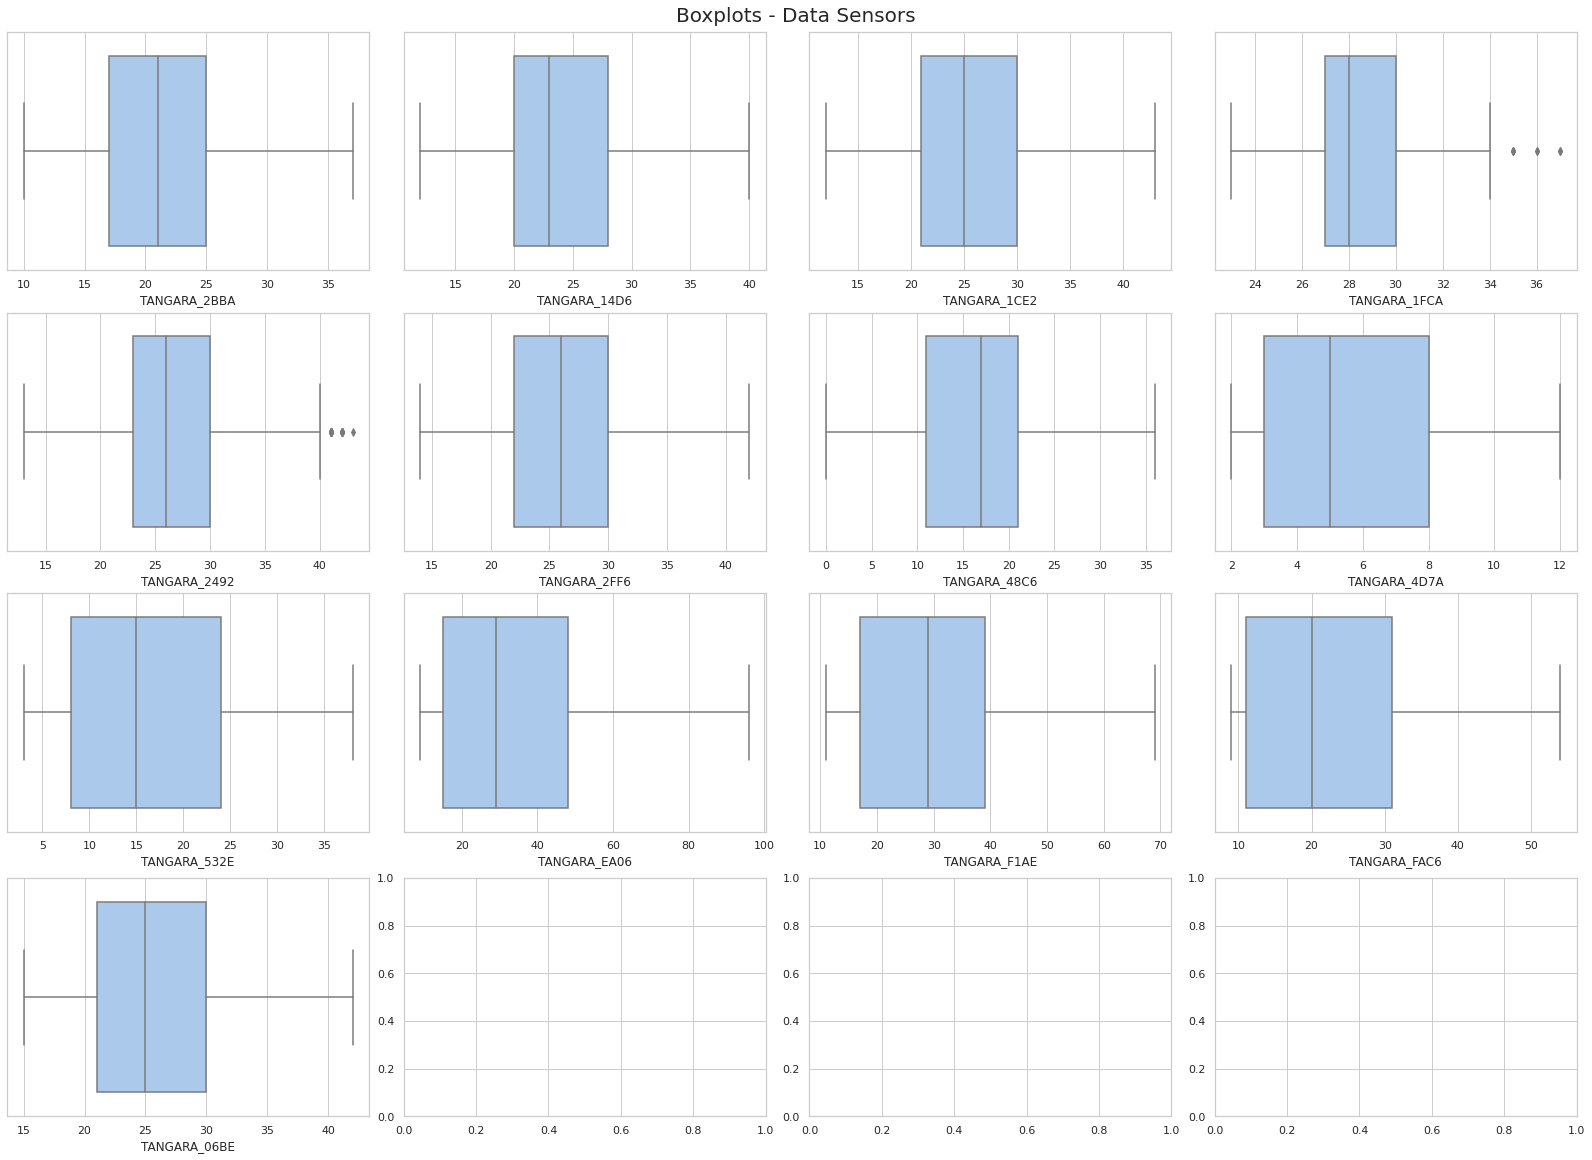

In [30]:
# Plot Boxplots
boxplots(pm25_clean)

In [31]:
# Plot Lineplots
def lineplots(data_sensors):
    fig, axes = plt.subplots(4, 4, figsize=(22, 16), constrained_layout=True)

    fig.suptitle('Timeline - Data Sensors', fontsize=20)

    size = len(data_sensors.describe().columns)
    k = 1
    for i in range(0, 4):
        for j in range(0, 4):
            if k <= size:
                sns.lineplot(ax=axes[i, j], data=data_sensors[data_sensors.columns[k]])
            k += 1

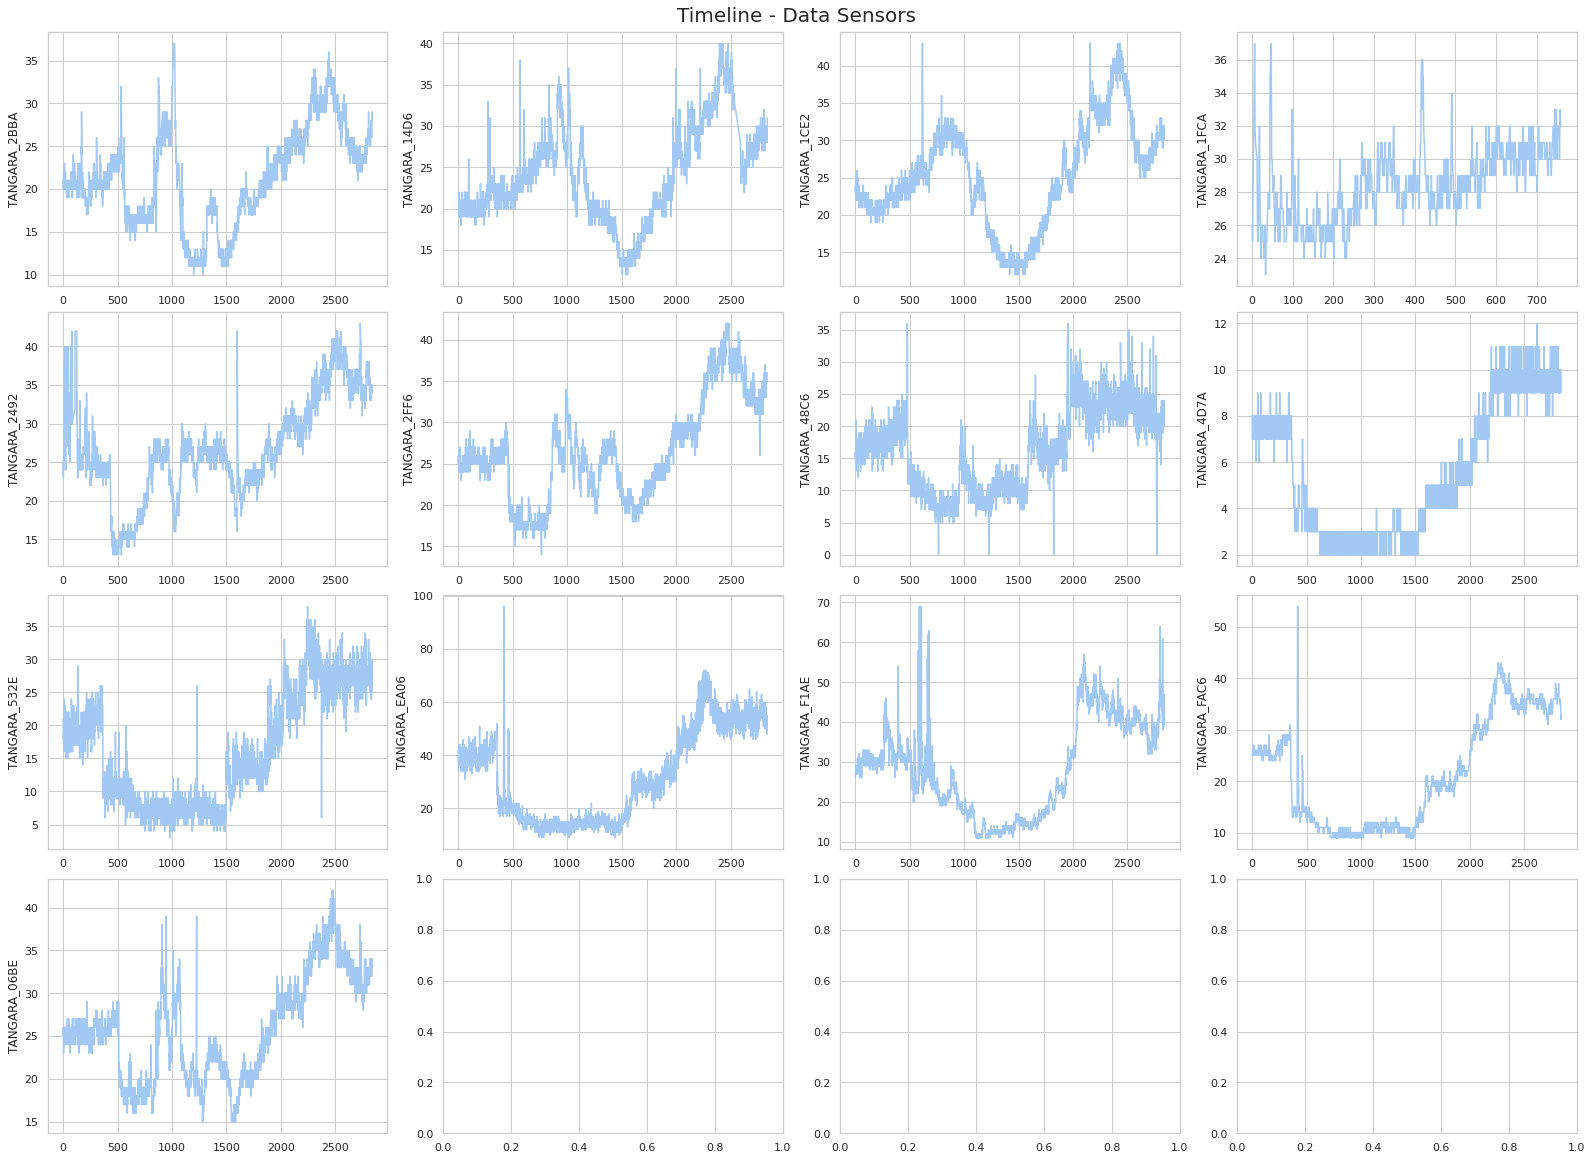

In [32]:
# Plot Lineplots
lineplots(pm25_clean)

In [33]:
# Save pm25_clean into Catalog
catalog.save('pm25_clean', pm25_clean)

2022-09-09 15:55:38,336 - kedro.io.data_catalog - INFO - Saving data to `pm25_clean` (CSVDataSet)...


---

## PM25 Last Hour

In [34]:
# Kedro Catalog
pm25_clean = catalog.load('pm25_clean')

2022-09-09 15:55:38,658 - kedro.io.data_catalog - INFO - Loading data from `pm25_clean` (CSVDataSet)...


In [35]:
# Data Frame Sensors
pm25_clean.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05T13:35:00-05:00,21.0,20.0,24.0,26.0,25.0,26.0,16.0,7.0,21.0,34.0,26.0,25.0,25.0
1,2022-09-05T13:35:30-05:00,20.0,20.0,23.0,25.0,24.0,25.0,15.0,7.0,19.0,42.0,26.0,25.0,26.0
2,2022-09-05T13:36:00-05:00,20.0,20.0,24.0,NaN,23.0,26.0,16.0,8.0,18.0,39.0,27.0,25.0,24.0
3,2022-09-05T13:36:30-05:00,21.0,20.0,24.0,NaN,25.0,24.0,16.0,8.0,19.0,36.0,29.0,25.0,24.0
4,2022-09-05T13:37:00-05:00,22.0,22.0,24.0,NaN,26.0,26.0,14.0,7.0,19.0,39.0,29.0,26.0,23.0


In [36]:
# Get pm25 resample mean last hour
def resample_pm25_last_hour(data_sensors):
    # Timestamp Format
    data_sensors['DATETIME'] = pd.to_datetime(data_sensors['DATETIME'])
    return data_sensors.resample('H', on='DATETIME', origin='end').mean().reset_index()#.median().reset_index()

In [37]:
# PM25 Last Hour
pm25_last_hour = resample_pm25_last_hour(pm25_clean)
pm25_last_hour.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05 14:34:30-05:00,20.625000,20.403361,22.369748,26.972973,30.030303,25.555556,16.848739,7.416667,19.350877,39.441667,29.707965,25.777778,25.285714
1,2022-09-05 15:34:30-05:00,20.175000,20.075630,20.764706,25.844828,26.931373,25.550847,17.672269,7.720339,19.452174,39.770642,30.155172,25.378151,25.474576
2,2022-09-05 16:34:30-05:00,20.883333,22.008333,21.826087,28.647059,24.864407,25.364407,18.075000,7.482456,21.422414,42.401786,34.887931,27.459459,25.403361
3,2022-09-05 17:34:30-05:00,21.862069,21.605263,23.203540,28.521739,20.973451,25.965217,20.112069,4.639640,11.300000,25.596154,32.184211,17.009434,26.096491
4,2022-09-05 18:34:30-05:00,22.025210,22.820513,24.872881,28.907563,14.803419,18.470588,12.239316,3.491379,10.336283,18.655172,29.198198,12.963303,21.186441


In [38]:
# Describe Data
pm25_clean.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2825.000000,2736.000000,2789.000000,742.000000,2705.000000,2801.000000,2794.000000,2763.000000,2691.000000,2748.000000,2766.000000,2735.000000,2792.000000
mean,21.327788,24.020102,25.221585,28.367925,26.601109,26.601928,16.342878,5.638075,16.209959,32.102620,28.351048,21.418647,25.695201
std,5.604861,5.766191,6.884397,2.175981,6.408280,5.989012,6.234398,2.852142,8.403760,17.128851,11.751590,10.360962,5.936232
min,10.000000,12.000000,12.000000,23.000000,13.000000,14.000000,0.000000,2.000000,3.000000,9.000000,11.000000,9.000000,15.000000
25%,17.000000,20.000000,21.000000,27.000000,23.000000,22.000000,11.000000,3.000000,8.000000,15.000000,17.000000,11.000000,21.000000
50%,21.000000,23.000000,25.000000,28.000000,26.000000,26.000000,17.000000,5.000000,15.000000,29.000000,29.000000,20.000000,25.000000
75%,25.000000,28.000000,30.000000,30.000000,30.000000,30.000000,21.000000,8.000000,24.000000,48.000000,39.000000,31.000000,30.000000
max,37.000000,40.000000,43.000000,37.000000,43.000000,42.000000,36.000000,12.000000,38.000000,96.000000,69.000000,54.000000,42.000000


In [39]:
# Describe Data
pm25_last_hour.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,24.000000,24.000000,24.000000,7.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.325800,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
std,5.380139,5.648283,6.808559,1.746974,6.082966,5.856329,5.811612,2.842651,8.238649,16.973664,11.381201,10.409445,5.680177
min,11.553398,14.211864,13.525000,25.844828,14.803419,17.767241,7.359649,2.364407,6.721739,12.966667,12.274510,9.666667,17.550847
25%,16.777083,20.321429,21.560742,27.747356,22.531780,23.104627,10.987500,2.857110,8.268553,14.903484,17.463007,10.891277,21.148164
50%,21.372701,23.868506,25.281573,28.647059,26.317797,25.795109,16.845203,4.788846,14.142788,28.766810,29.453081,19.430172,25.438969
75%,24.925000,27.645209,29.999620,29.562477,29.885781,29.120089,20.939890,7.875724,24.363551,47.478992,38.426029,30.458387,29.193147
max,31.416667,36.269565,39.508475,30.914894,38.922414,38.241667,25.282051,9.773913,30.801802,62.641509,46.000000,40.179245,36.805085


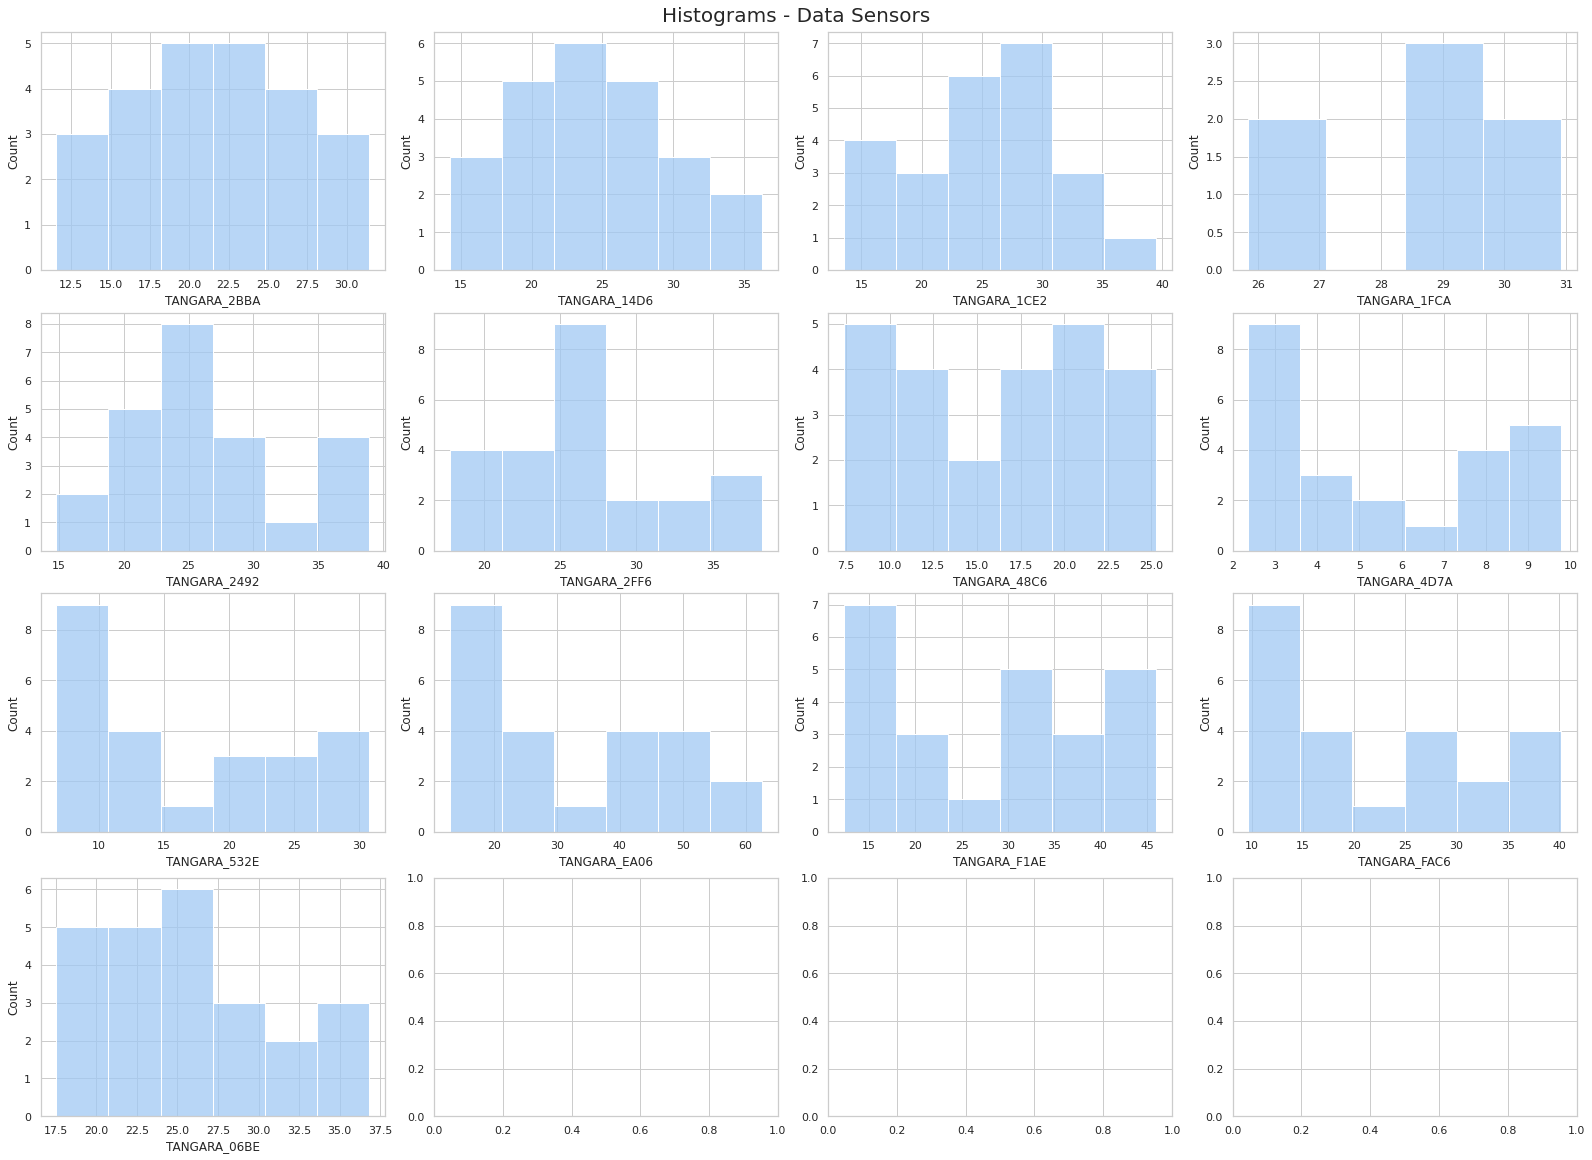

In [40]:
# Plot Histograms
histplots(pm25_last_hour)

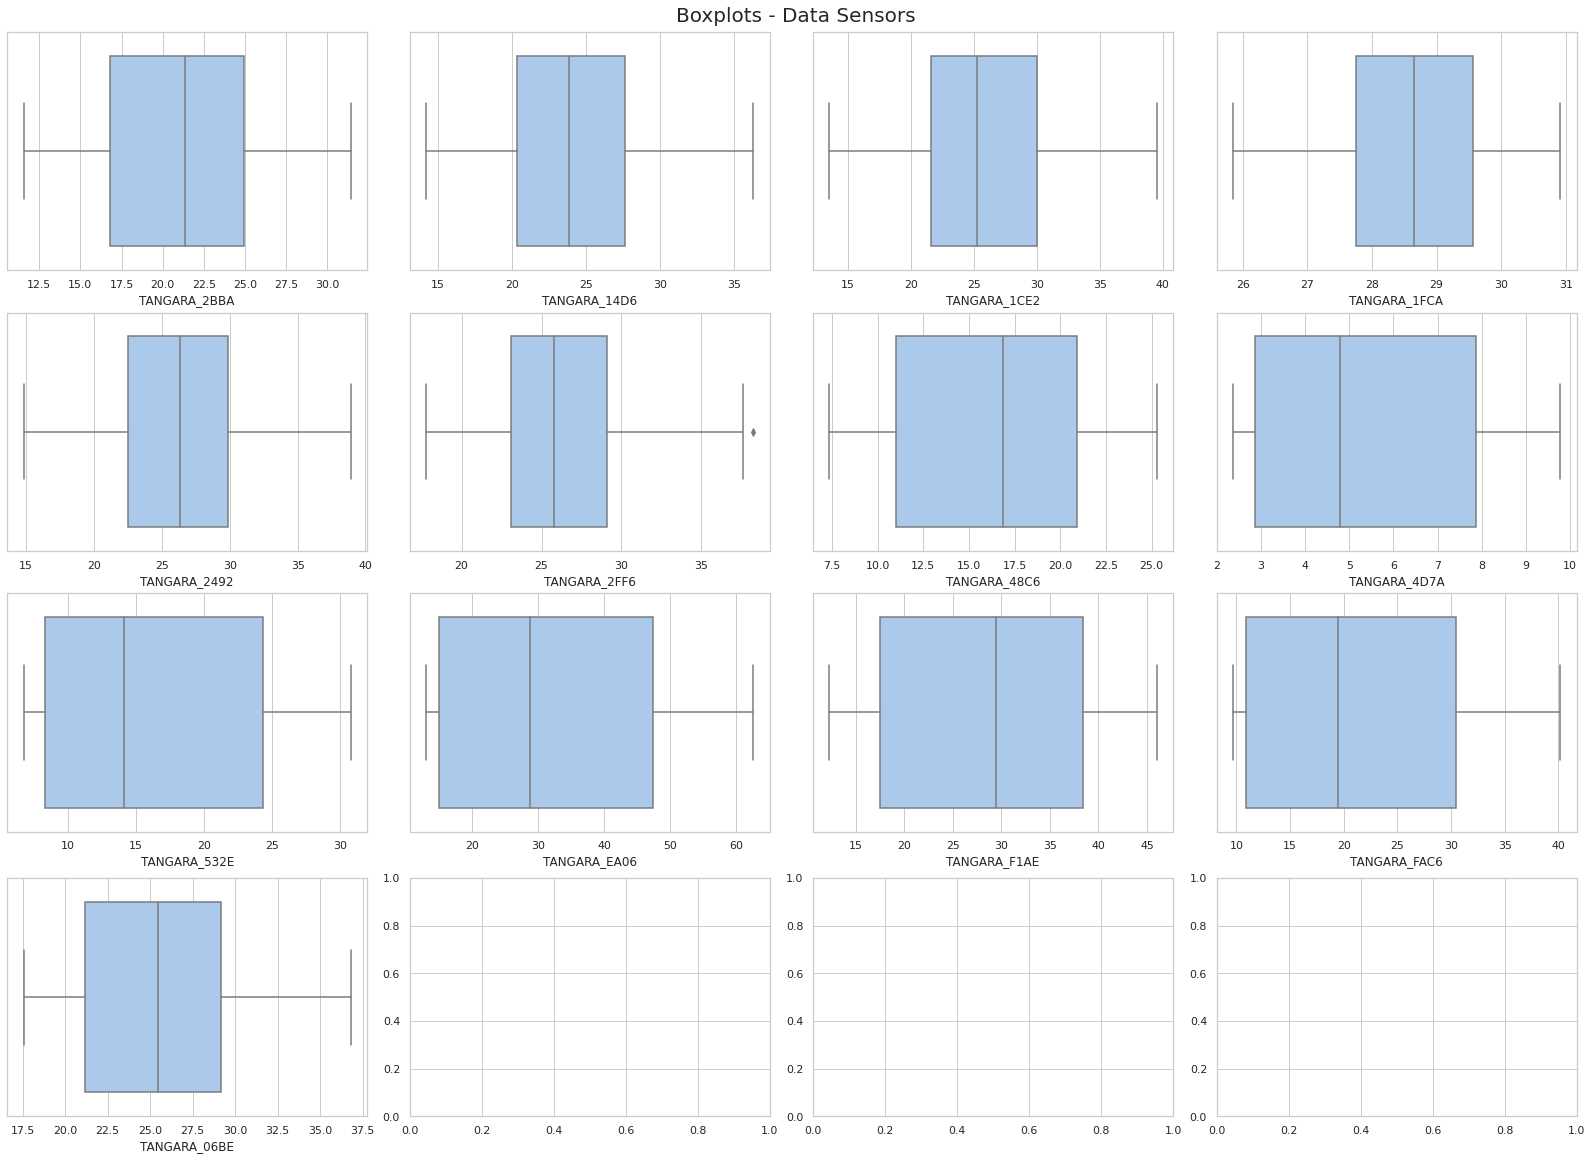

In [41]:
# Plot Boxplots
boxplots(pm25_last_hour)

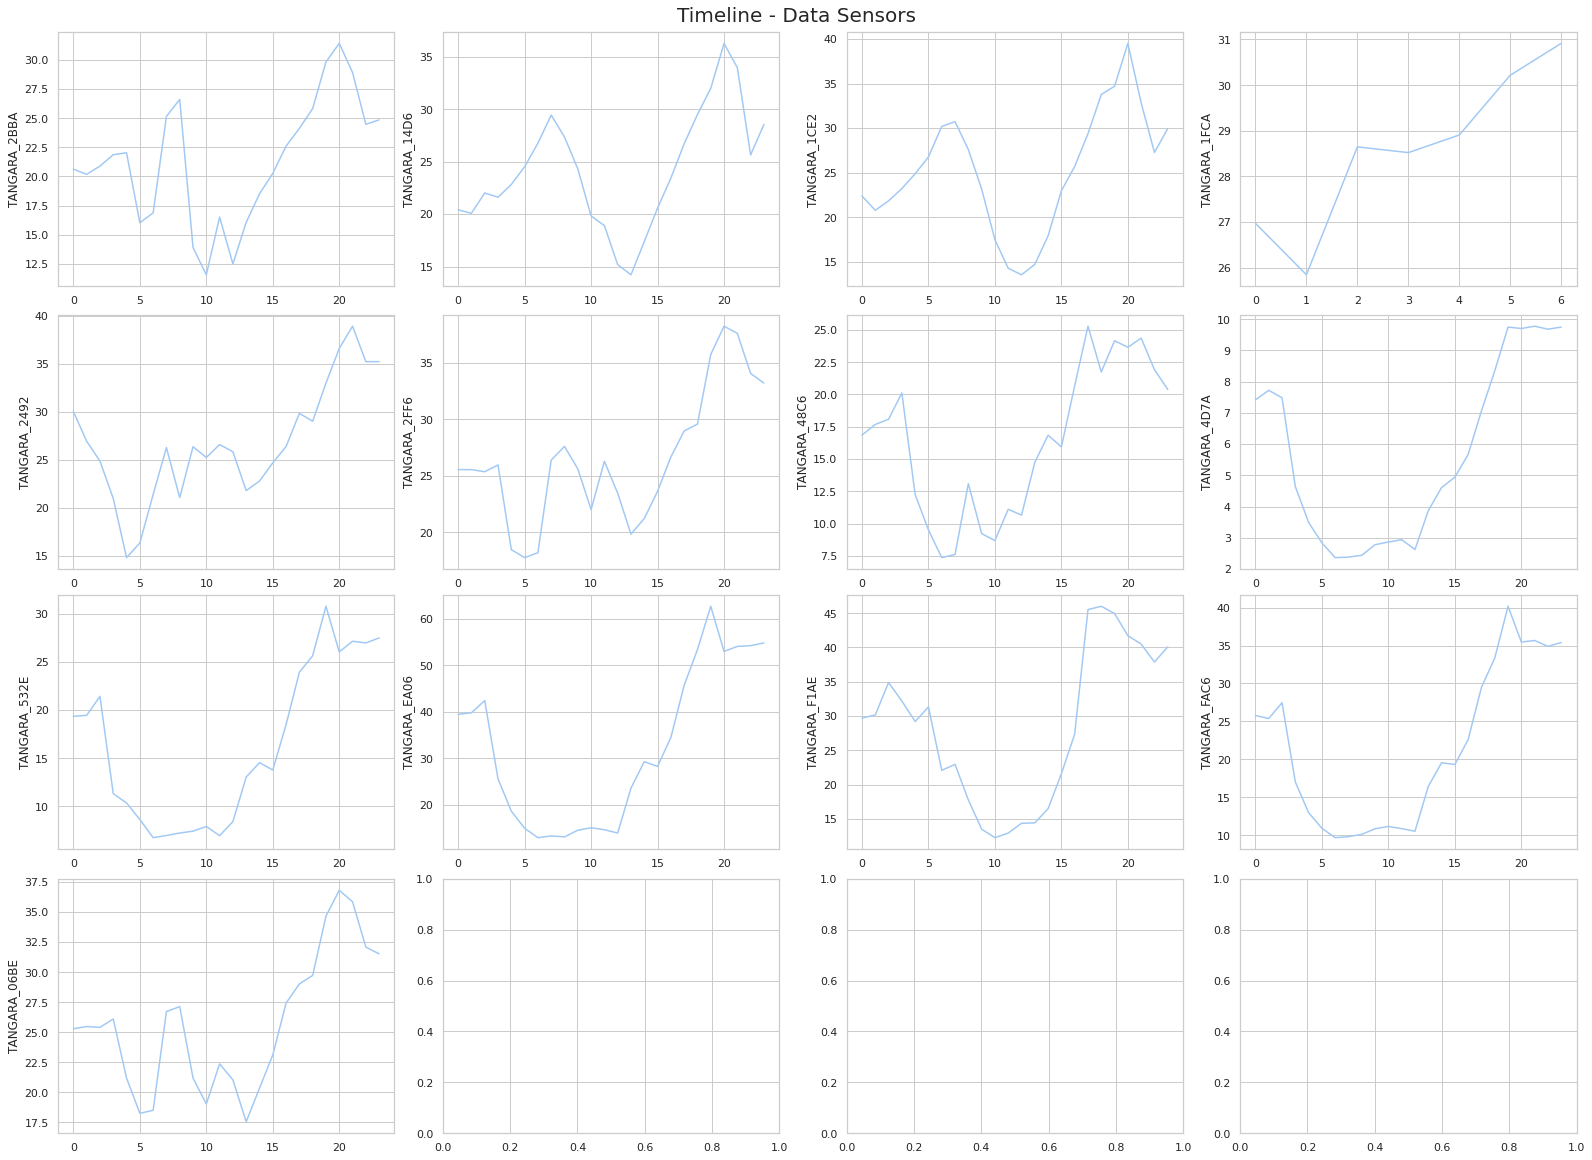

In [42]:
# Plot Lineplots
lineplots(pm25_last_hour)

In [43]:
# Save pm25_last_hour into Catalog
catalog.save('pm25_last_hour', pm25_last_hour)

2022-09-09 15:56:01,920 - kedro.io.data_catalog - INFO - Saving data to `pm25_last_hour` (CSVDataSet)...


---

## PM25 Last 8 Hours

In [44]:
# Kedro Catalog
pm25_last_hour = catalog.load('pm25_last_hour')

2022-09-09 15:56:02,180 - kedro.io.data_catalog - INFO - Loading data from `pm25_last_hour` (CSVDataSet)...


In [45]:
# Data Frame Sensors
pm25_last_hour.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05 14:34:30-05:00,20.625000,20.403361,22.369748,26.972973,30.030303,25.555556,16.848739,7.416667,19.350877,39.441667,29.707965,25.777778,25.285714
1,2022-09-05 15:34:30-05:00,20.175000,20.075630,20.764706,25.844828,26.931373,25.550847,17.672269,7.720339,19.452174,39.770642,30.155172,25.378151,25.474576
2,2022-09-05 16:34:30-05:00,20.883333,22.008333,21.826087,28.647059,24.864407,25.364407,18.075000,7.482456,21.422414,42.401786,34.887931,27.459459,25.403361
3,2022-09-05 17:34:30-05:00,21.862069,21.605263,23.203540,28.521739,20.973451,25.965217,20.112069,4.639640,11.300000,25.596154,32.184211,17.009434,26.096491
4,2022-09-05 18:34:30-05:00,22.025210,22.820513,24.872881,28.907563,14.803419,18.470588,12.239316,3.491379,10.336283,18.655172,29.198198,12.963303,21.186441


In [46]:
# Get pm25 resample mean last 8 hours
def resample_pm25_last_8h(data_sensors):
    # Timestamp Format
    data_sensors['DATETIME'] = pd.to_datetime(data_sensors['DATETIME'])
    return data_sensors.resample('8H', on='DATETIME', origin='end').mean().reset_index()#.median().reset_index()

In [47]:
# PM25 Last Hour
pm25_last_hour.tail()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
19,2022-09-06 09:34:30-05:00,29.820513,31.974138,34.698276,NaN,32.991379,35.735043,24.156522,9.745283,30.801802,62.641509,44.938053,40.179245,34.655172
20,2022-09-06 10:34:30-05:00,31.416667,36.269565,39.508475,NaN,36.598291,38.241667,23.649573,9.700000,26.044248,52.949580,41.711864,35.462185,36.805085
21,2022-09-06 11:34:30-05:00,28.915966,33.952381,32.826087,NaN,38.922414,37.605042,24.358974,9.773913,27.160714,54.017391,40.483051,35.666667,35.855932
22,2022-09-06 12:34:30-05:00,24.470588,25.634783,27.256410,NaN,35.224138,34.059829,21.915254,9.678261,26.982456,54.187500,37.872881,34.880734,32.076271
23,2022-09-06 13:34:30-05:00,24.850000,28.538462,29.940171,NaN,35.232143,33.213675,20.382609,9.745763,27.508929,54.762712,40.085470,35.401709,31.517241


In [48]:
# PM25 Last 8 Hours
pm25_last_8h = resample_pm25_last_8h(pm25_last_hour)
pm25_last_8h.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05 21:34:30-05:00,20.450529,23.451424,25.085717,28.575207,22.697279,22.909232,13.676092,4.791453,13.017816,25.894800,29.063319,17.369896,23.365145
1,2022-09-06 05:34:30-05:00,16.983224,19.714861,18.941228,NaN,24.291987,23.714422,12.531423,3.381996,9.891306,19.070315,15.427135,13.594368,21.467174
2,2022-09-06 13:34:30-05:00,26.500840,29.497655,31.632161,NaN,33.025487,33.009407,22.769886,8.714268,25.822648,51.503171,40.498112,33.380570,32.133223


In [49]:
# Describe Data
pm25_last_hour.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,24.000000,24.000000,24.000000,7.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.325800,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
std,5.380139,5.648283,6.808559,1.746974,6.082966,5.856329,5.811612,2.842651,8.238649,16.973664,11.381201,10.409445,5.680177
min,11.553398,14.211864,13.525000,25.844828,14.803419,17.767241,7.359649,2.364407,6.721739,12.966667,12.274510,9.666667,17.550847
25%,16.777083,20.321429,21.560742,27.747356,22.531780,23.104627,10.987500,2.857110,8.268553,14.903484,17.463007,10.891277,21.148164
50%,21.372701,23.868506,25.281573,28.647059,26.317797,25.795109,16.845203,4.788846,14.142788,28.766810,29.453081,19.430172,25.438969
75%,24.925000,27.645209,29.999620,29.562477,29.885781,29.120089,20.939890,7.875724,24.363551,47.478992,38.426029,30.458387,29.193147
max,31.416667,36.269565,39.508475,30.914894,38.922414,38.241667,25.282051,9.773913,30.801802,62.641509,46.000000,40.179245,36.805085


In [50]:
# Describe Data
pm25_last_8h.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,3.000000,3.000000,3.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.325800,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
std,4.816871,4.936629,6.346527,NaN,5.560111,5.613356,5.610013,2.763095,8.441430,17.098988,12.551586,10.504682,5.689846
min,16.983224,19.714861,18.941228,28.575207,22.697279,22.909232,12.531423,3.381996,9.891306,19.070315,15.427135,13.594368,21.467174
25%,18.716876,21.583143,22.013473,28.575207,23.494633,23.311827,13.103757,4.086725,11.454561,22.482558,22.245227,15.482132,22.416160
50%,20.450529,23.451424,25.085717,28.575207,24.291987,23.714422,13.676092,4.791453,13.017816,25.894800,29.063319,17.369896,23.365145
75%,23.475684,26.474539,28.358939,28.575207,28.658737,28.361914,18.222989,6.752861,19.420232,38.698985,34.780715,25.375233,27.749184
max,26.500840,29.497655,31.632161,28.575207,33.025487,33.009407,22.769886,8.714268,25.822648,51.503171,40.498112,33.380570,32.133223


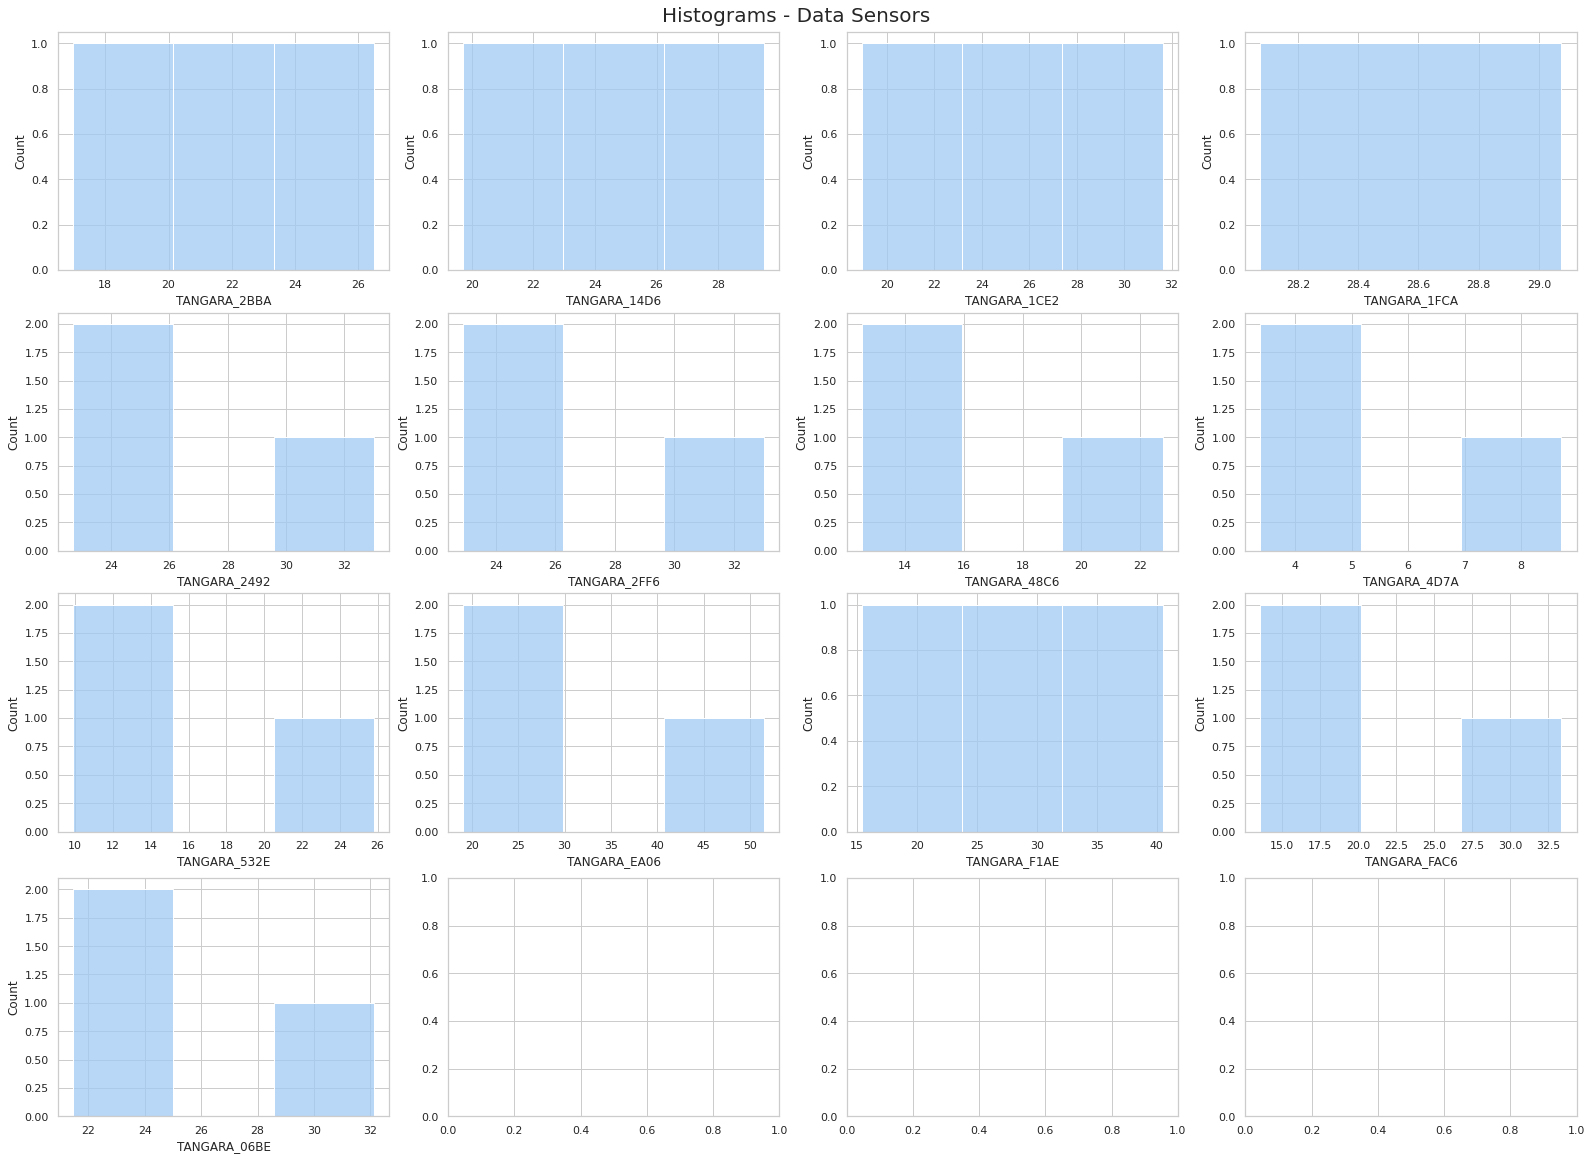

In [51]:
# Plot Histograms
histplots(pm25_last_8h)

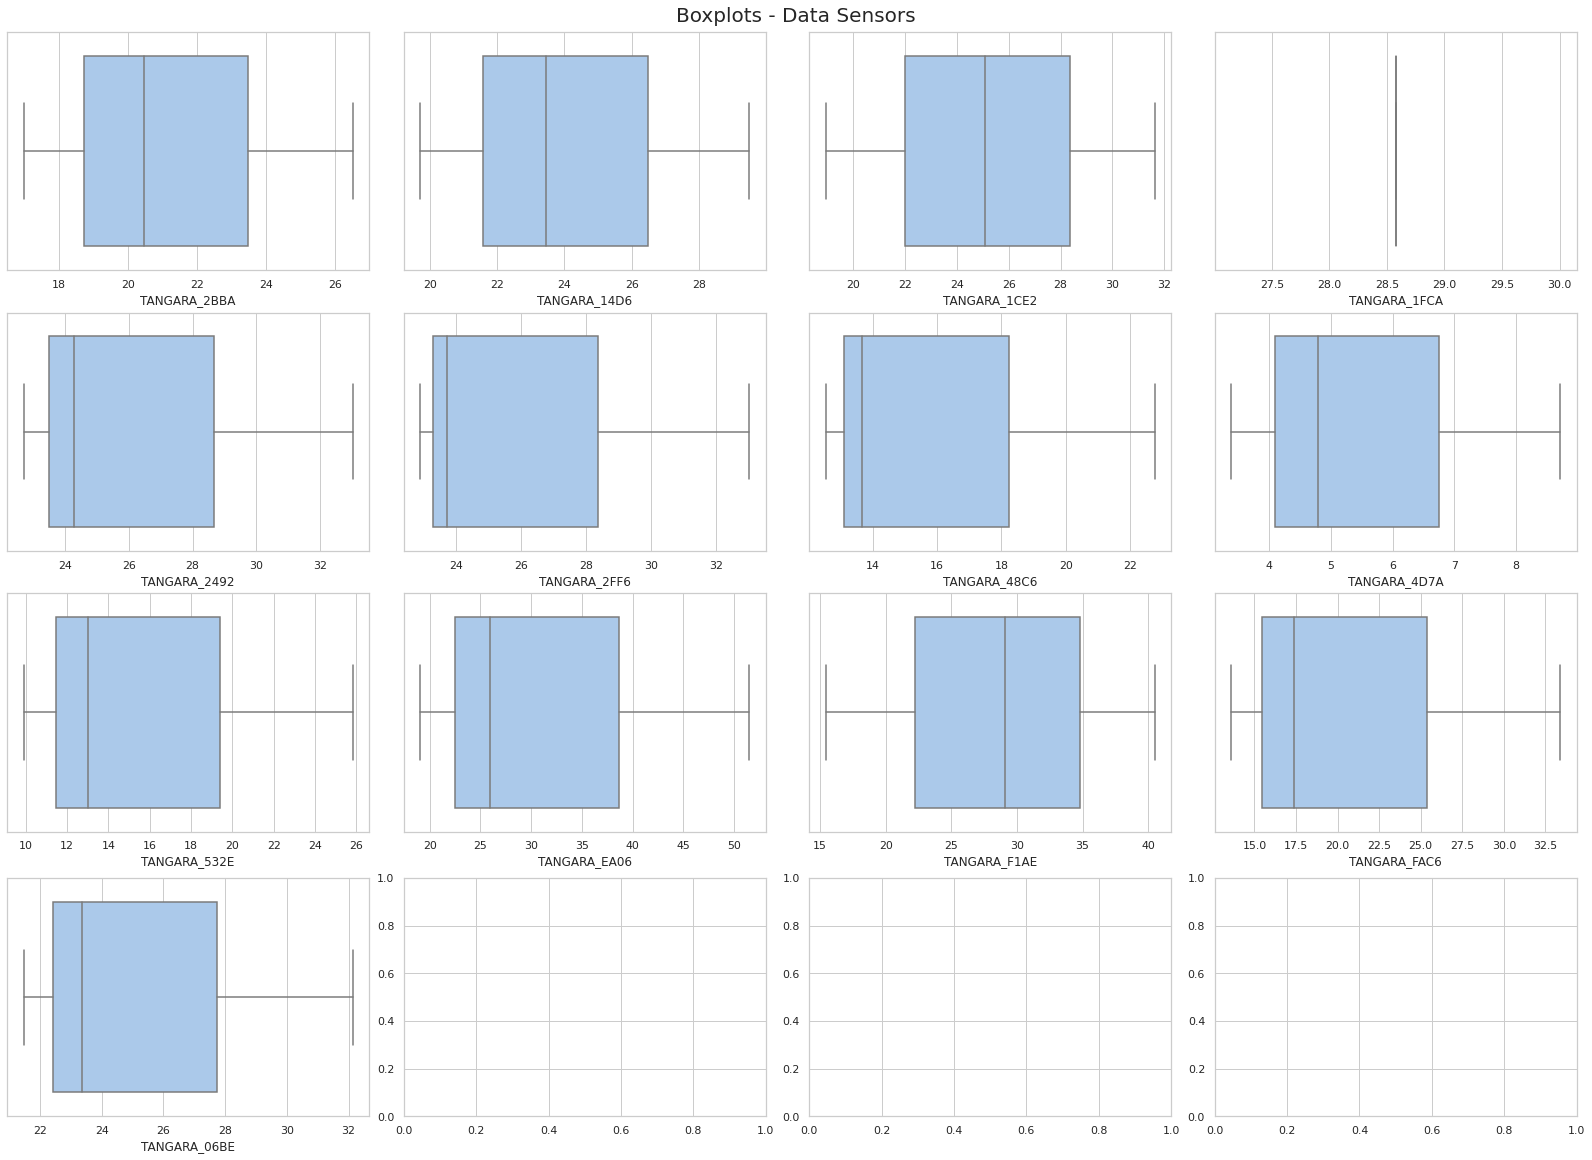

In [52]:
# Plot Boxplots
boxplots(pm25_last_8h)

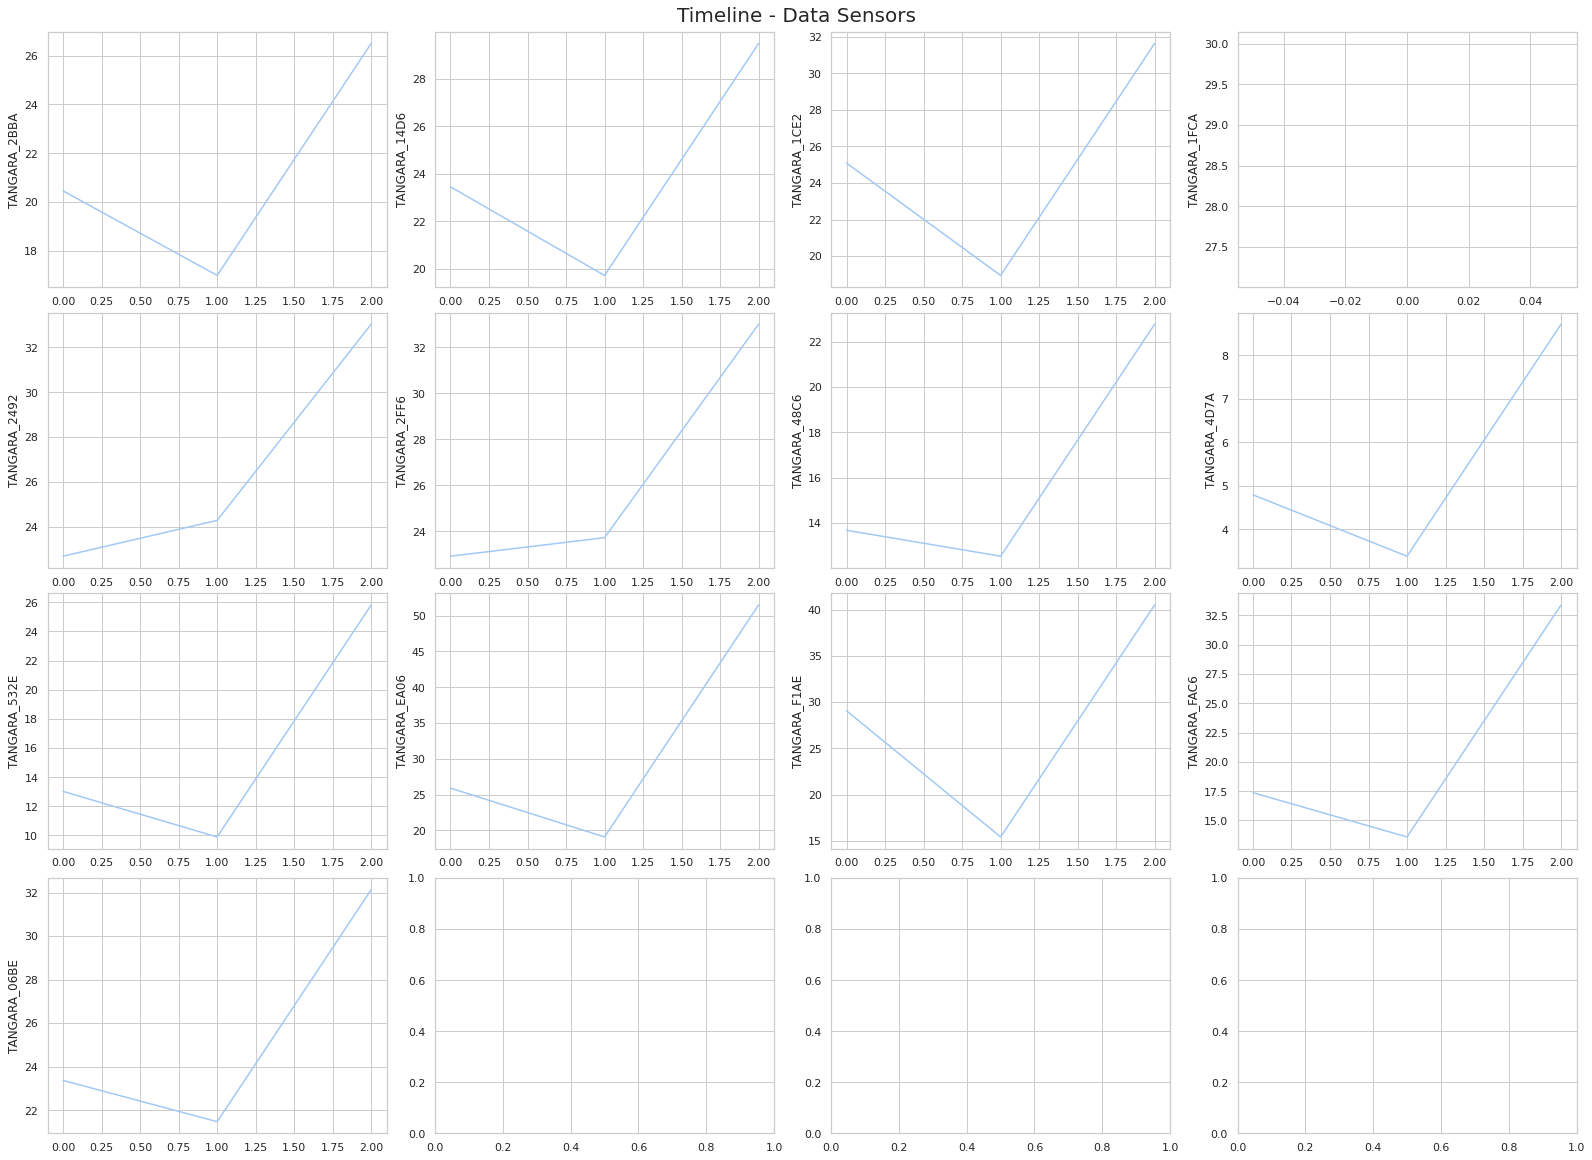

In [53]:
# Plot Lineplots
lineplots(pm25_last_8h)

In [54]:
# Save pm25_last_8h into Catalog
catalog.save('pm25_last_8h', pm25_last_8h)

2022-09-09 15:56:27,120 - kedro.io.data_catalog - INFO - Saving data to `pm25_last_8h` (CSVDataSet)...


---

## PM25 Last 12 Hours

In [55]:
# Kedro Catalog
pm25_last_hour = catalog.load('pm25_last_hour')

2022-09-09 15:56:27,465 - kedro.io.data_catalog - INFO - Loading data from `pm25_last_hour` (CSVDataSet)...


In [56]:
# Data Frame Sensors
pm25_last_hour.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05 14:34:30-05:00,20.625000,20.403361,22.369748,26.972973,30.030303,25.555556,16.848739,7.416667,19.350877,39.441667,29.707965,25.777778,25.285714
1,2022-09-05 15:34:30-05:00,20.175000,20.075630,20.764706,25.844828,26.931373,25.550847,17.672269,7.720339,19.452174,39.770642,30.155172,25.378151,25.474576
2,2022-09-05 16:34:30-05:00,20.883333,22.008333,21.826087,28.647059,24.864407,25.364407,18.075000,7.482456,21.422414,42.401786,34.887931,27.459459,25.403361
3,2022-09-05 17:34:30-05:00,21.862069,21.605263,23.203540,28.521739,20.973451,25.965217,20.112069,4.639640,11.300000,25.596154,32.184211,17.009434,26.096491
4,2022-09-05 18:34:30-05:00,22.025210,22.820513,24.872881,28.907563,14.803419,18.470588,12.239316,3.491379,10.336283,18.655172,29.198198,12.963303,21.186441


In [57]:
# Get pm25 resample mean last 12 hours
def resample_pm25_last_12h(data_sensors):
    # Timestamp Format
    data_sensors['DATETIME'] = pd.to_datetime(data_sensors['DATETIME'])
    return data_sensors.resample('12H', on='DATETIME', origin='end').mean().reset_index()#.median().reset_index()

In [58]:
# PM25 Last Hour
pm25_last_hour.tail()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
19,2022-09-06 09:34:30-05:00,29.820513,31.974138,34.698276,NaN,32.991379,35.735043,24.156522,9.745283,30.801802,62.641509,44.938053,40.179245,34.655172
20,2022-09-06 10:34:30-05:00,31.416667,36.269565,39.508475,NaN,36.598291,38.241667,23.649573,9.700000,26.044248,52.949580,41.711864,35.462185,36.805085
21,2022-09-06 11:34:30-05:00,28.915966,33.952381,32.826087,NaN,38.922414,37.605042,24.358974,9.773913,27.160714,54.017391,40.483051,35.666667,35.855932
22,2022-09-06 12:34:30-05:00,24.470588,25.634783,27.256410,NaN,35.224138,34.059829,21.915254,9.678261,26.982456,54.187500,37.872881,34.880734,32.076271
23,2022-09-06 13:34:30-05:00,24.850000,28.538462,29.940171,NaN,35.232143,33.213675,20.382609,9.745763,27.508929,54.762712,40.085470,35.401709,31.517241


In [59]:
# PM25 Last 12 Hours
pm25_last_12h = resample_pm25_last_12h(pm25_last_hour)
pm25_last_12h.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-06 01:34:30-05:00,19.347478,23.165593,23.595339,28.575207,23.402513,23.734368,12.624426,4.112644,11.130586,22.051994,24.085174,15.159342,23.052585
1,2022-09-06 13:34:30-05:00,23.275584,25.277034,26.844065,NaN,29.940656,29.354339,20.027175,7.145834,21.357261,42.260197,32.573870,27.737214,28.257776


In [60]:
# Describe Data
pm25_last_hour.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,24.000000,24.000000,24.000000,7.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.325800,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
std,5.380139,5.648283,6.808559,1.746974,6.082966,5.856329,5.811612,2.842651,8.238649,16.973664,11.381201,10.409445,5.680177
min,11.553398,14.211864,13.525000,25.844828,14.803419,17.767241,7.359649,2.364407,6.721739,12.966667,12.274510,9.666667,17.550847
25%,16.777083,20.321429,21.560742,27.747356,22.531780,23.104627,10.987500,2.857110,8.268553,14.903484,17.463007,10.891277,21.148164
50%,21.372701,23.868506,25.281573,28.647059,26.317797,25.795109,16.845203,4.788846,14.142788,28.766810,29.453081,19.430172,25.438969
75%,24.925000,27.645209,29.999620,29.562477,29.885781,29.120089,20.939890,7.875724,24.363551,47.478992,38.426029,30.458387,29.193147
max,31.416667,36.269565,39.508475,30.914894,38.922414,38.241667,25.282051,9.773913,30.801802,62.641509,46.000000,40.179245,36.805085


In [61]:
# Describe Data
pm25_last_12h.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.325800,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
std,2.777591,1.493014,2.297196,NaN,4.623165,3.973919,5.234534,2.144789,7.231352,14.289357,6.002414,8.893899,3.680626
min,19.347478,23.165593,23.595339,28.575207,23.402513,23.734368,12.624426,4.112644,11.130586,22.051994,24.085174,15.159342,23.052585
25%,20.329504,23.693453,24.407521,28.575207,25.037049,25.139361,14.475113,4.870942,13.687254,27.104044,26.207348,18.303810,24.353883
50%,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.325800,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
75%,22.293557,24.749174,26.031884,28.575207,28.306120,27.949346,18.176488,6.387537,18.800592,37.208146,30.451696,24.592746,26.956478
max,23.275584,25.277034,26.844065,28.575207,29.940656,29.354339,20.027175,7.145834,21.357261,42.260197,32.573870,27.737214,28.257776


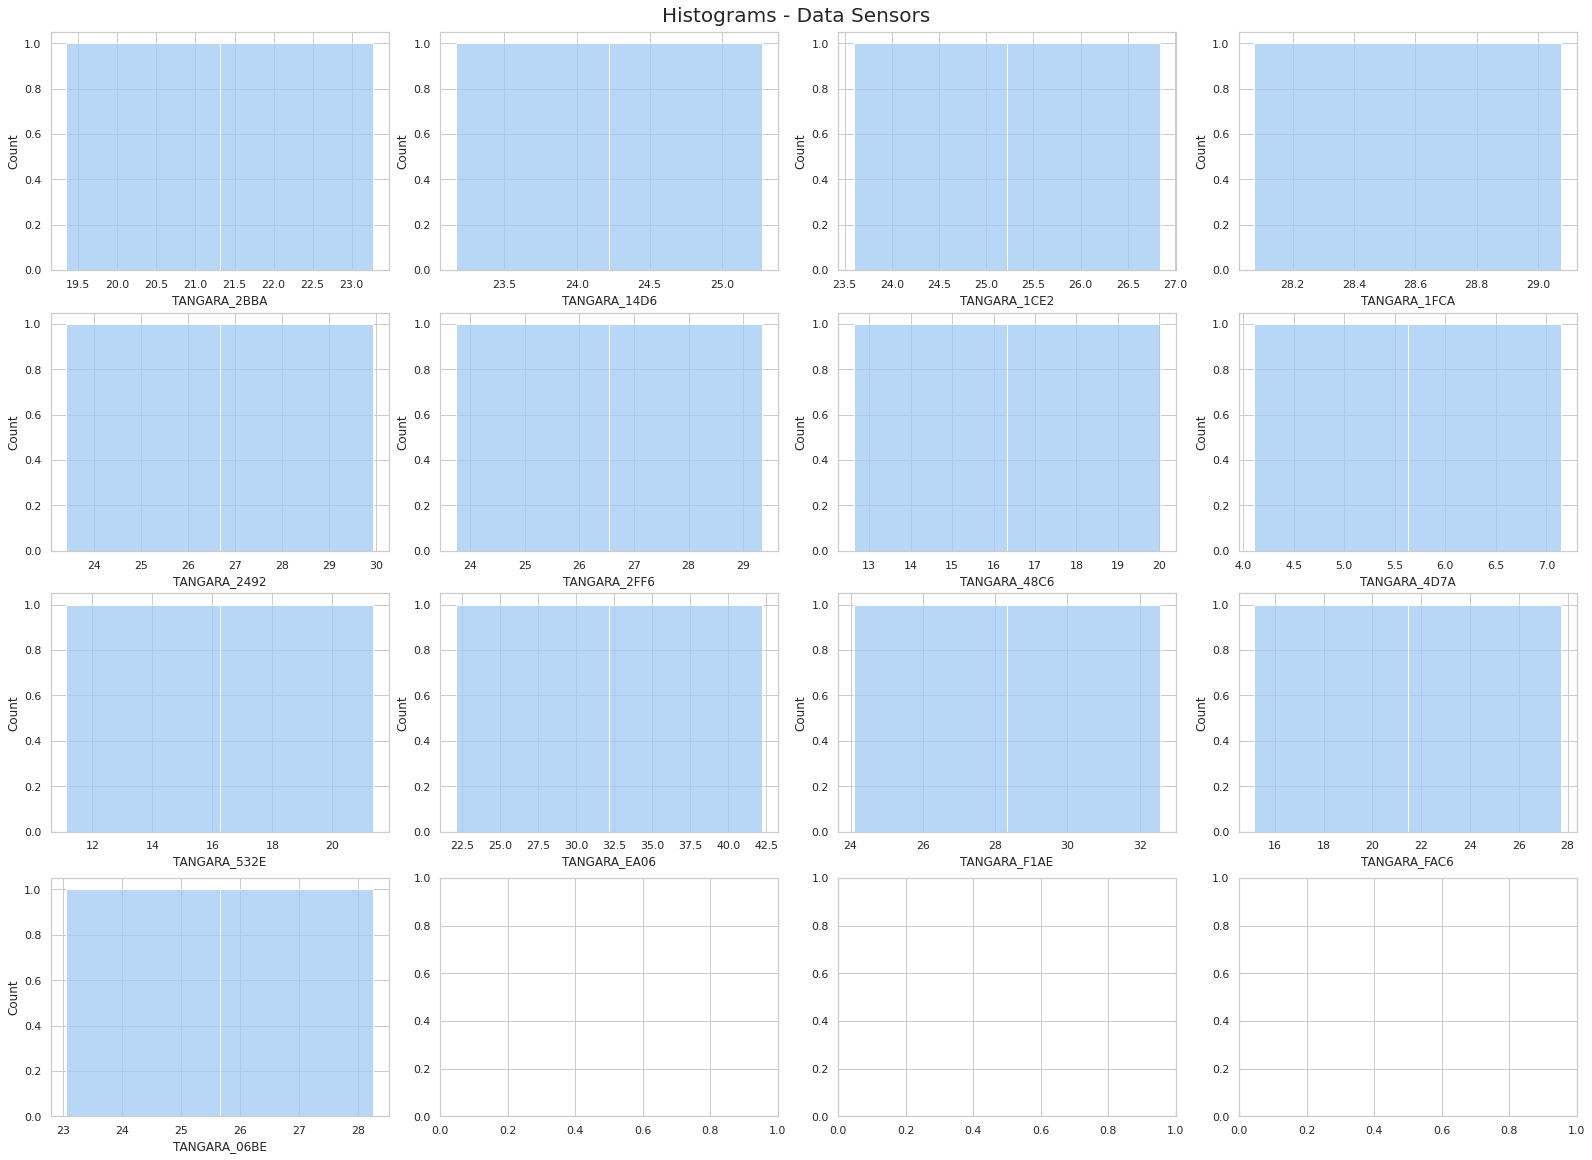

In [62]:
# Plot Histograms
histplots(pm25_last_12h)

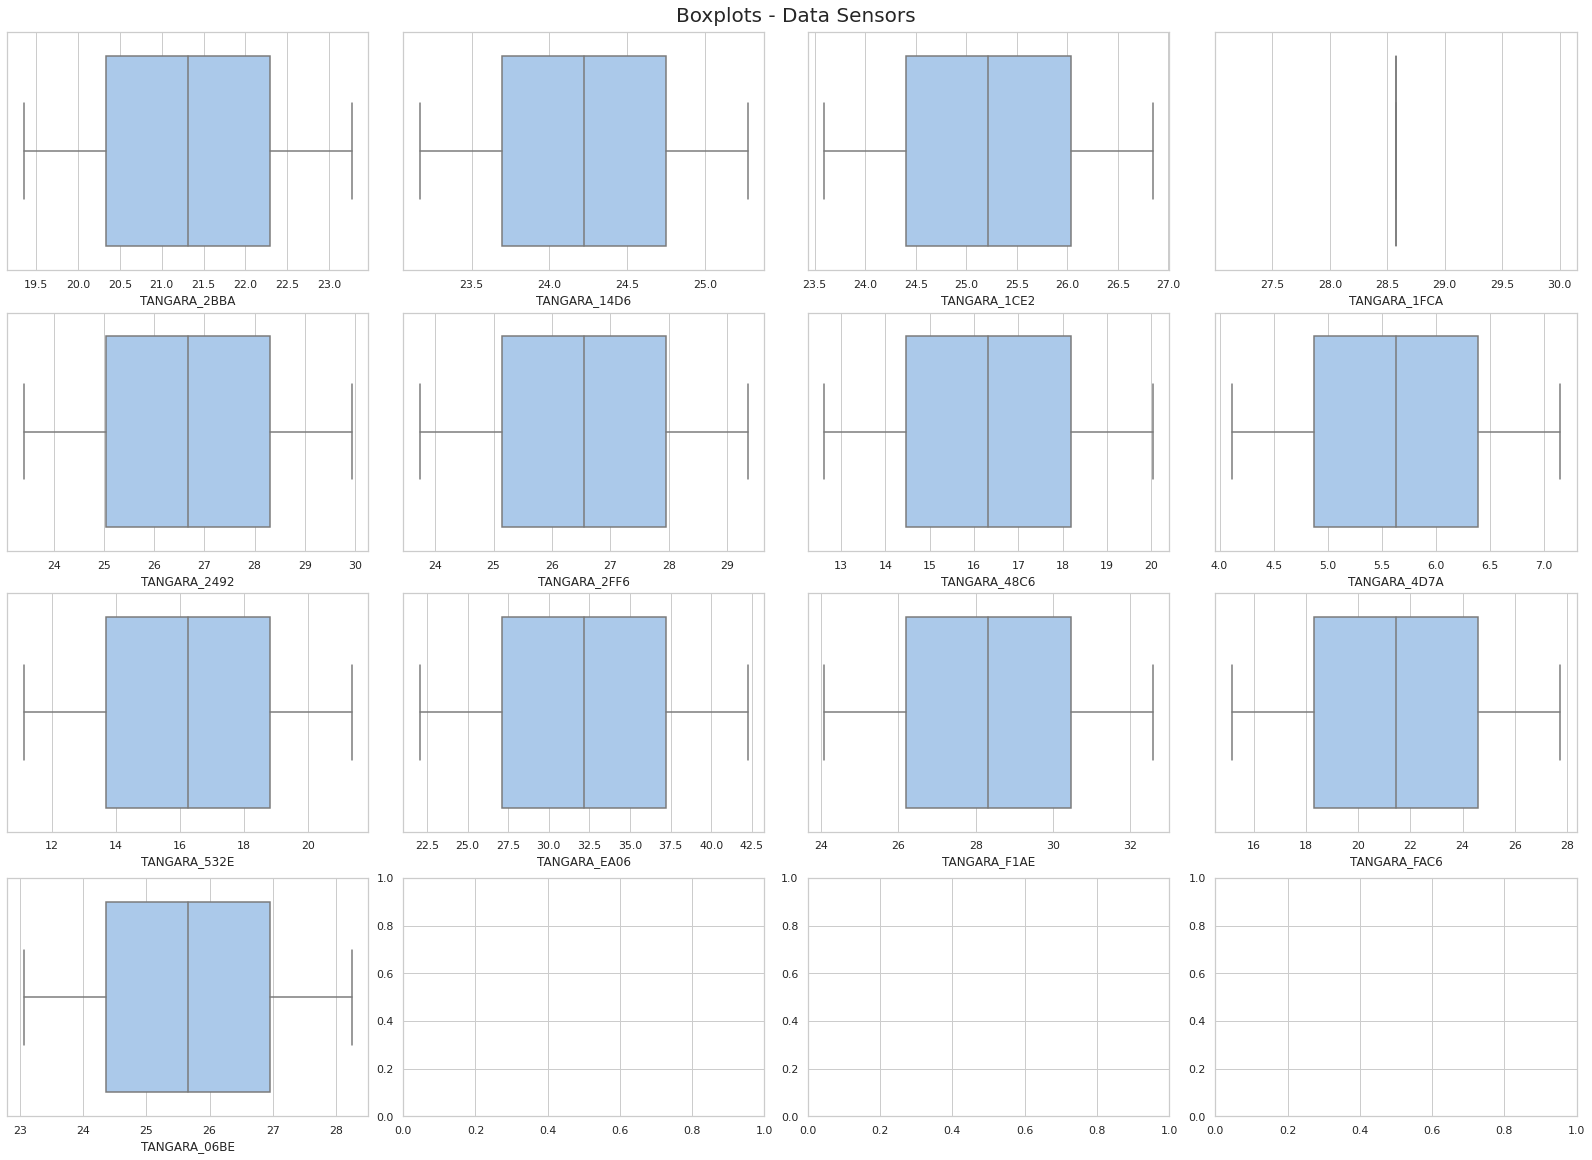

In [63]:
# Plot Boxplots
boxplots(pm25_last_12h)

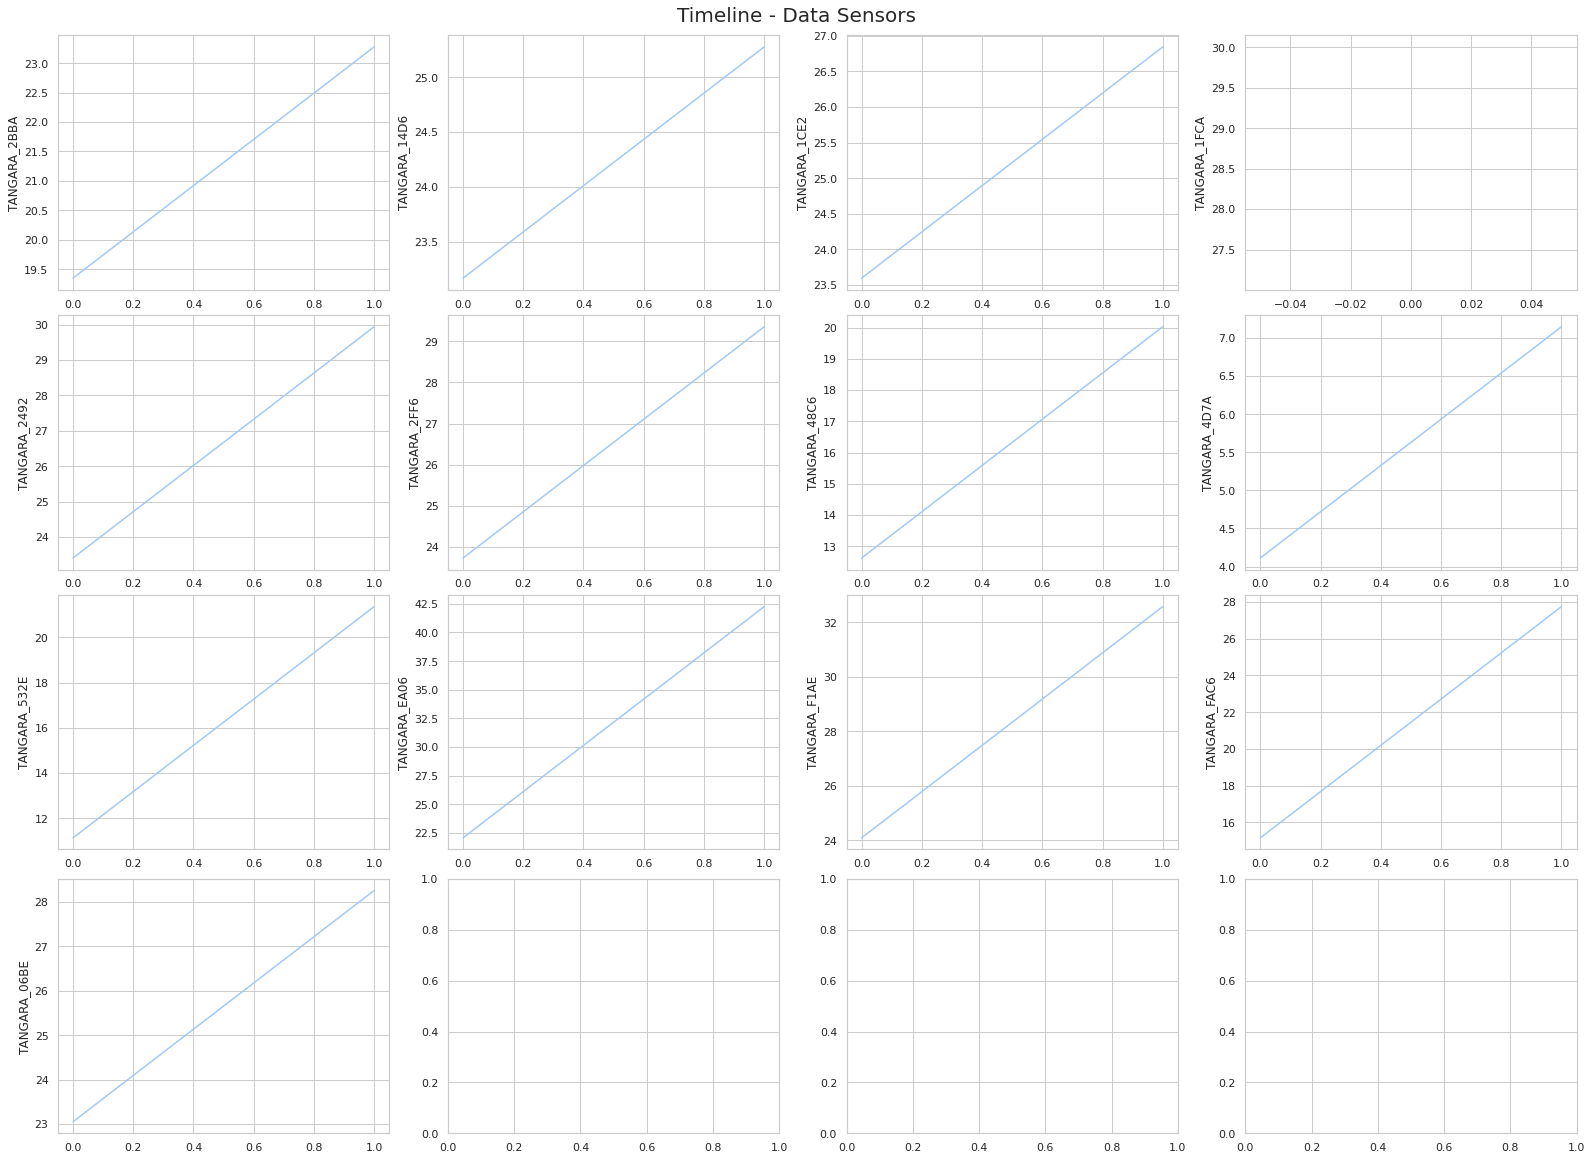

In [64]:
# Plot Lineplots
lineplots(pm25_last_12h)

In [65]:
# Save pm25_last_12h into Catalog
catalog.save('pm25_last_12h', pm25_last_12h)

2022-09-09 15:56:52,365 - kedro.io.data_catalog - INFO - Saving data to `pm25_last_12h` (CSVDataSet)...


---

## PM25 Last 24 Hours

In [66]:
# Kedro Catalog
pm25_last_hour = catalog.load('pm25_last_hour')

2022-09-09 15:56:52,688 - kedro.io.data_catalog - INFO - Loading data from `pm25_last_hour` (CSVDataSet)...


In [67]:
# Data Frame Sensors
pm25_last_hour.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-05 14:34:30-05:00,20.625000,20.403361,22.369748,26.972973,30.030303,25.555556,16.848739,7.416667,19.350877,39.441667,29.707965,25.777778,25.285714
1,2022-09-05 15:34:30-05:00,20.175000,20.075630,20.764706,25.844828,26.931373,25.550847,17.672269,7.720339,19.452174,39.770642,30.155172,25.378151,25.474576
2,2022-09-05 16:34:30-05:00,20.883333,22.008333,21.826087,28.647059,24.864407,25.364407,18.075000,7.482456,21.422414,42.401786,34.887931,27.459459,25.403361
3,2022-09-05 17:34:30-05:00,21.862069,21.605263,23.203540,28.521739,20.973451,25.965217,20.112069,4.639640,11.300000,25.596154,32.184211,17.009434,26.096491
4,2022-09-05 18:34:30-05:00,22.025210,22.820513,24.872881,28.907563,14.803419,18.470588,12.239316,3.491379,10.336283,18.655172,29.198198,12.963303,21.186441


In [68]:
# Get pm25 resample mean last 24 hours
def resample_pm25_last_24h(data_sensors):
    # Timestamp Format
    data_sensors['DATETIME'] = pd.to_datetime(data_sensors['DATETIME'])
    return data_sensors.resample('24H', on='DATETIME', origin='end').mean().reset_index()#.median().reset_index()

In [69]:
# PM25 Last Hour
pm25_last_hour.tail()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
19,2022-09-06 09:34:30-05:00,29.820513,31.974138,34.698276,NaN,32.991379,35.735043,24.156522,9.745283,30.801802,62.641509,44.938053,40.179245,34.655172
20,2022-09-06 10:34:30-05:00,31.416667,36.269565,39.508475,NaN,36.598291,38.241667,23.649573,9.700000,26.044248,52.949580,41.711864,35.462185,36.805085
21,2022-09-06 11:34:30-05:00,28.915966,33.952381,32.826087,NaN,38.922414,37.605042,24.358974,9.773913,27.160714,54.017391,40.483051,35.666667,35.855932
22,2022-09-06 12:34:30-05:00,24.470588,25.634783,27.256410,NaN,35.224138,34.059829,21.915254,9.678261,26.982456,54.187500,37.872881,34.880734,32.076271
23,2022-09-06 13:34:30-05:00,24.850000,28.538462,29.940171,NaN,35.232143,33.213675,20.382609,9.745763,27.508929,54.762712,40.085470,35.401709,31.517241


In [70]:
# PM25 Last 24 Hours
pm25_last_24h = resample_pm25_last_24h(pm25_last_hour)
pm25_last_24h.head()

,DATETIME,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
0,2022-09-06 13:34:30-05:00,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181


In [71]:
# Describe Data
pm25_last_hour.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,24.000000,24.000000,24.000000,7.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.325800,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
std,5.380139,5.648283,6.808559,1.746974,6.082966,5.856329,5.811612,2.842651,8.238649,16.973664,11.381201,10.409445,5.680177
min,11.553398,14.211864,13.525000,25.844828,14.803419,17.767241,7.359649,2.364407,6.721739,12.966667,12.274510,9.666667,17.550847
25%,16.777083,20.321429,21.560742,27.747356,22.531780,23.104627,10.987500,2.857110,8.268553,14.903484,17.463007,10.891277,21.148164
50%,21.372701,23.868506,25.281573,28.647059,26.317797,25.795109,16.845203,4.788846,14.142788,28.766810,29.453081,19.430172,25.438969
75%,24.925000,27.645209,29.999620,29.562477,29.885781,29.120089,20.939890,7.875724,24.363551,47.478992,38.426029,30.458387,29.193147
max,31.416667,36.269565,39.508475,30.914894,38.922414,38.241667,25.282051,9.773913,30.801802,62.641509,46.000000,40.179245,36.805085


In [72]:
# Describe Data
pm25_last_24h.describe()

,TANGARA_2BBA,TANGARA_14D6,TANGARA_1CE2,TANGARA_1FCA,TANGARA_2492,TANGARA_2FF6,TANGARA_48C6,TANGARA_4D7A,TANGARA_532E,TANGARA_EA06,TANGARA_F1AE,TANGARA_FAC6,TANGARA_06BE
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
25%,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
50%,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
75%,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181
max,21.311531,24.221313,25.219702,28.575207,26.671584,26.544354,16.3258,5.629239,16.243923,32.156095,28.329522,21.448278,25.655181


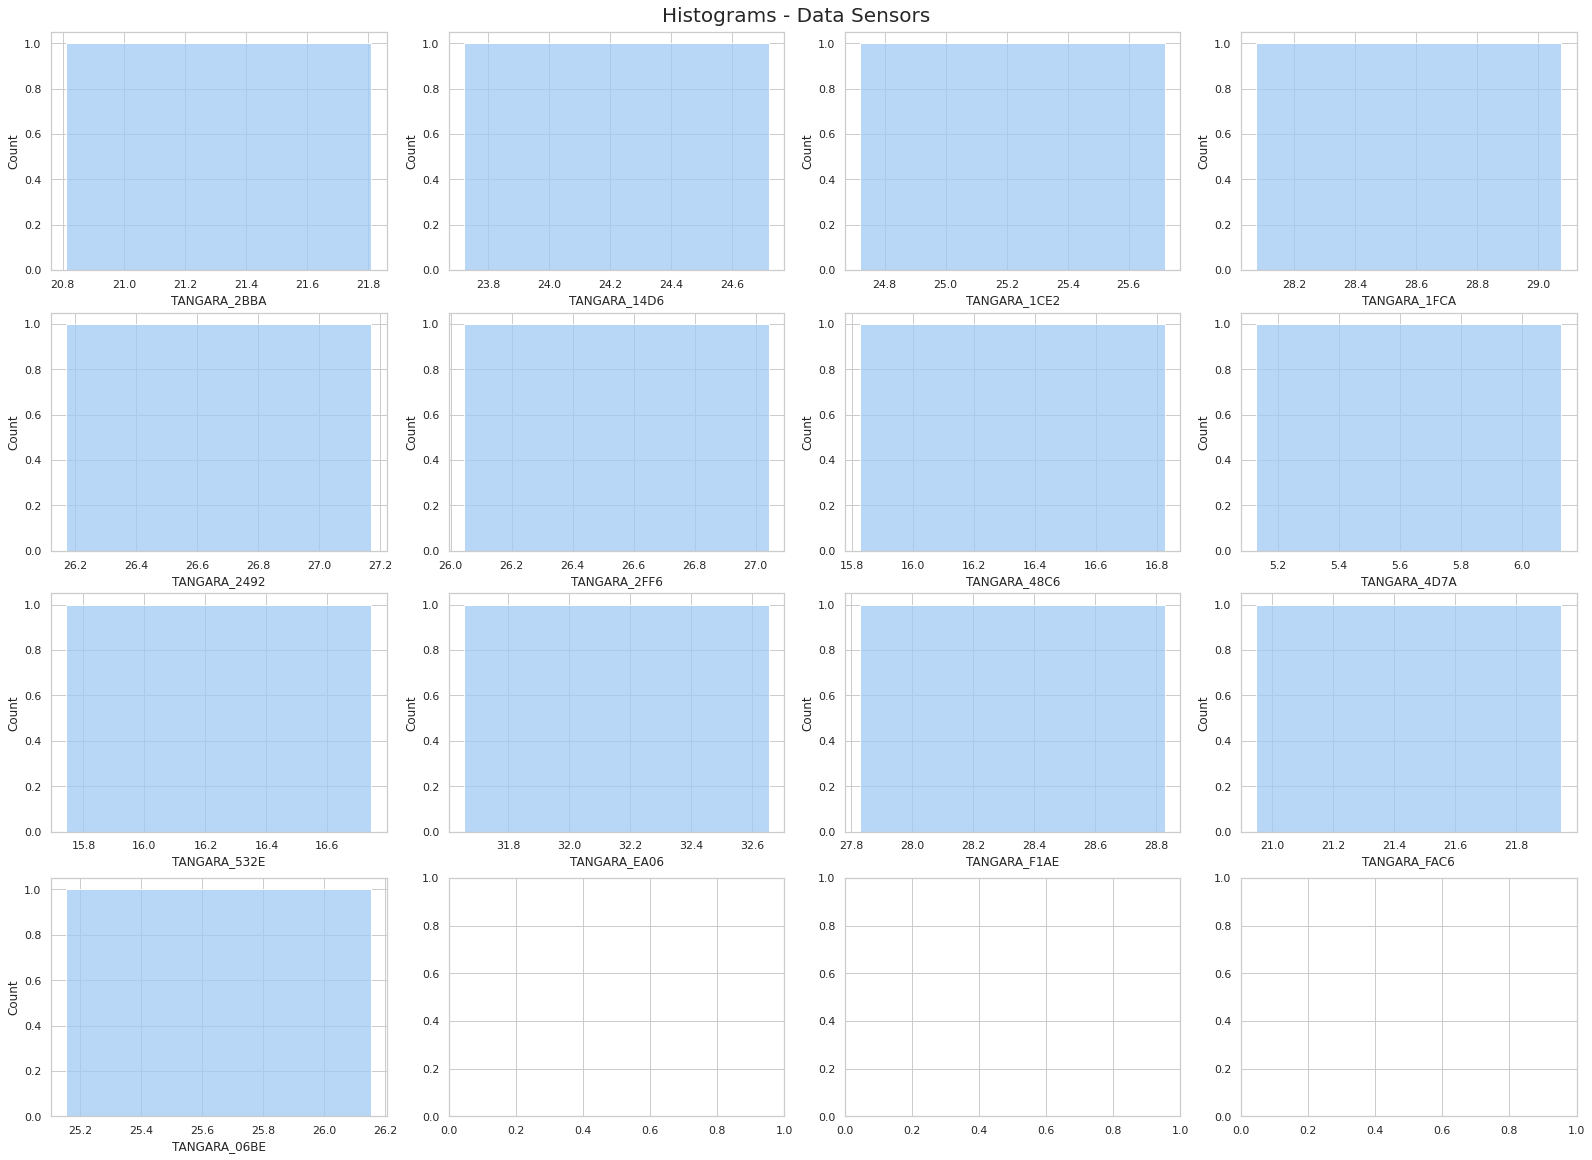

In [73]:
# Plot Histograms
histplots(pm25_last_24h)

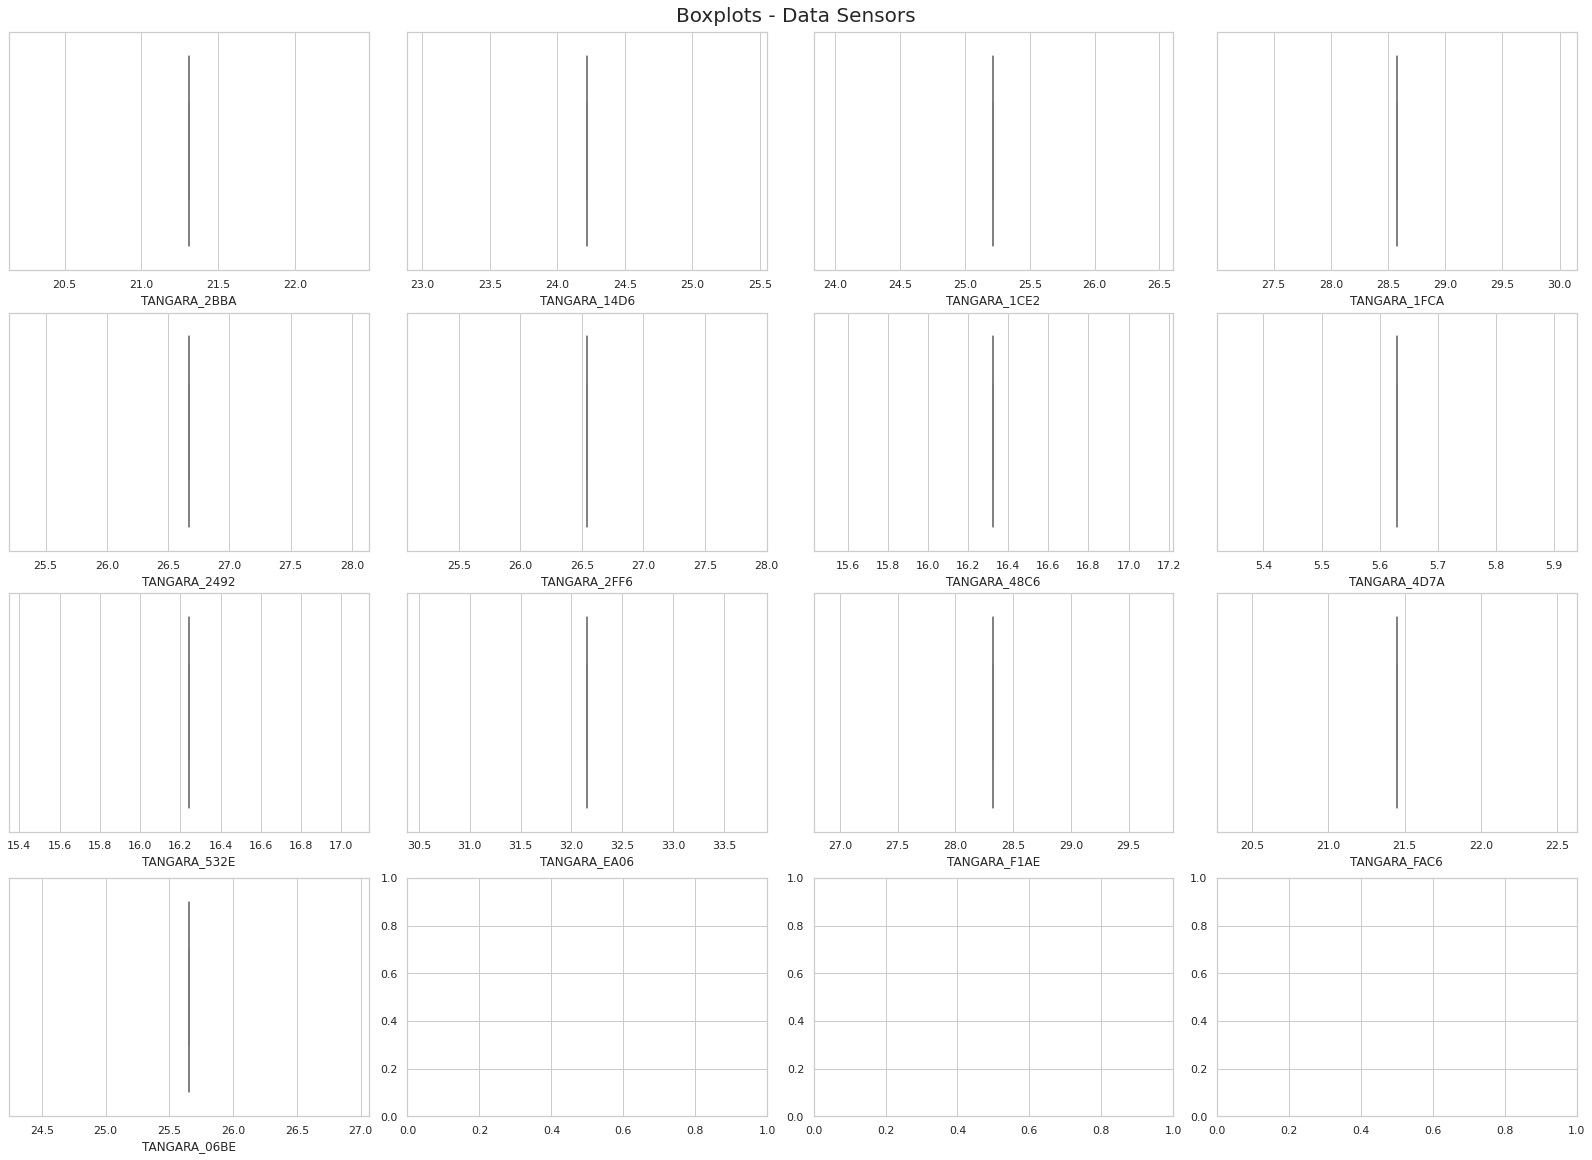

In [74]:
# Plot Boxplots
boxplots(pm25_last_24h)

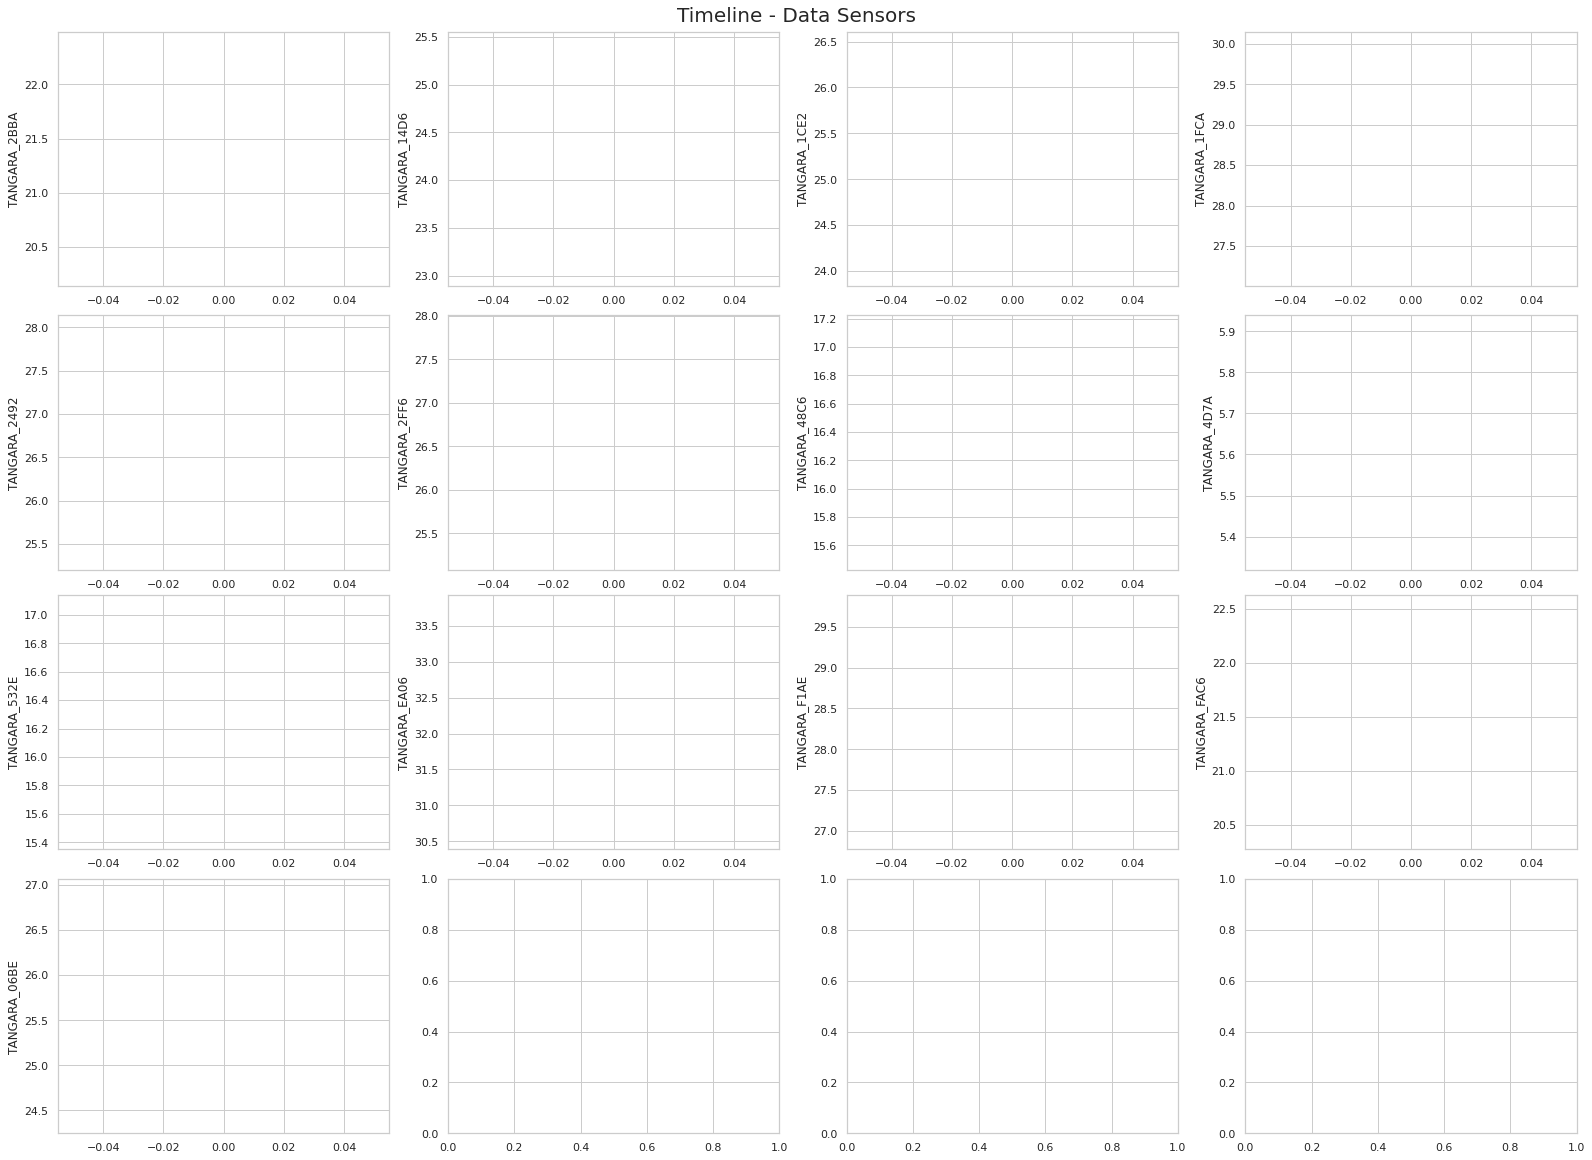

In [75]:
# Plot Lineplots
lineplots(pm25_last_24h)

In [76]:
# Save pm25_last_24h into Catalog
catalog.save('pm25_last_24h', pm25_last_24h)

2022-09-09 15:57:16,106 - kedro.io.data_catalog - INFO - Saving data to `pm25_last_24h` (CSVDataSet)...
